# Final Project EEG Classification

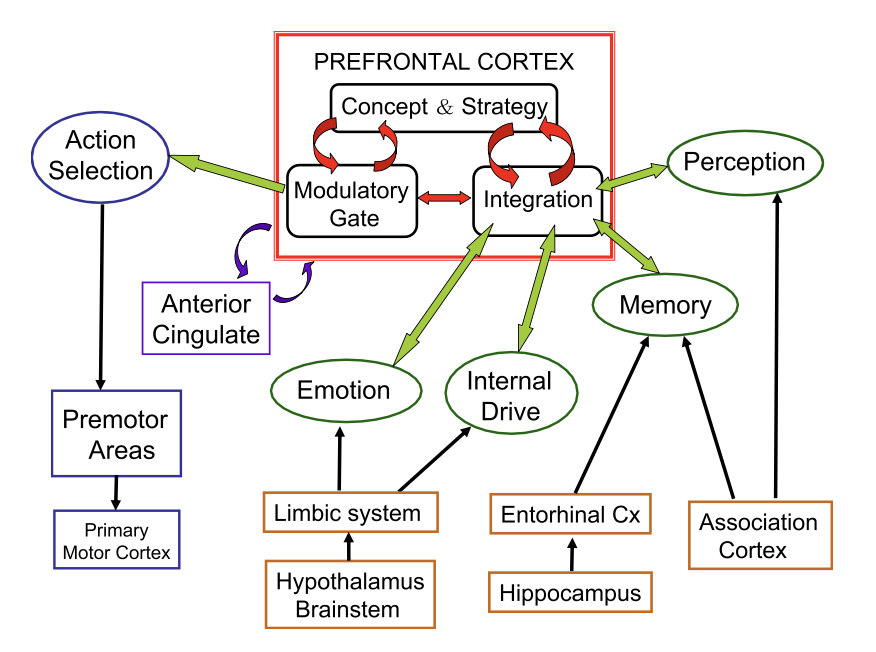

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="mkl")
warnings.filterwarnings("ignore")

In [ ]:
import os
import random
import shutil

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

import pyeeg
from PIL import Image
from functools import reduce

from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
from scipy.signal import spectrogram
from scipy.io import loadmat

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold,cross_validate
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D, MaxPooling1D, Conv2D, Conv1D, Add
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Reshape, Input, Dropout
from tensorflow.keras.layers import LSTM, BatchNormalization, ReLU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2


## Data Cleaning

In [3]:
data = pd.read_csv('emotions.csv')
data.head()

# mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  mean_d_1_a  \
0        4.62      30.3    -356.0      15.6      26.3       1.070       0.411   
1       28.80      33.1      32.0      25.8      22.8       6.550       1.680   
2        8.90      29.4    -416.0      16.7      23.7      79.900       3.360   
3       14.90      31.6    -143.0      19.8      24.3      -0.584      -0.284   
4       28.30      31.3      45.2      27.3      24.5      34.800      -5.790   

   mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  fft_742_b  fft_743_b  \
0      -15.70        2.06        3.15  ...       23.5       20.3       20.3   
1        2.88        3.83       -4.82  ...      -23.3      -21.8      -21.8   
2       90.20       89.90        2.03  ...      462.0     -233.0     -233.0   
3        8.82        2.30       -1.97  ...      299.0     -243.0     -243.0   
4        3.06       41.40        5.52  ...       12.0       38.1       38.1   

   fft_744_b  fft_745_b  fft_746_b  fft_747_b  fft_748_b  fft_749_b     label  
0       23.5     -215.0     280.00    -162.00    -162.00     280.00  NEGATIVE  
1      -23.3      182.0       2.57     -31.60     -31.60       2.57   NEUTRAL  
2      462.0     -267.0     281.00    -148.00    -148.00     281.00  POSITIVE  
3      299.0      132.0     -12.40       9.53       9.53     -12.40  POSITIVE  
4       12.0      119.0     -17.60      23.90      23.90     -17.60   NEUTRAL  

[5 rows x 2549 columns]

In [4]:
columns_to_keep = [col for col in data.columns if col.startswith('fft') or col == 'label']

In [5]:
data = data[columns_to_keep]
data.head()

fft_0_a  fft_1_a  fft_2_a  fft_3_a  fft_4_a  fft_5_a  fft_6_a  fft_7_a  \
0   -520.0   398.00   -201.0   -201.0   398.00    -52.2   121.00    -64.0   
1     66.2    -4.30     43.6     43.6    -4.30     66.0   -29.00     73.3   
2    -90.8   204.00    -77.1    -77.1   204.00   -488.0   415.00   -187.0   
3    119.0     6.25     10.9     10.9     6.25   -333.0   283.00   -144.0   
4     59.0    -2.37     10.8     10.8    -2.37    118.0    -1.81     26.7   

   fft_8_a  fft_9_a  ...  fft_741_b  fft_742_b  fft_743_b  fft_744_b  \
0    -64.0   121.00  ...       23.5       20.3       20.3       23.5   
1     73.3   -29.00  ...      -23.3      -21.8      -21.8      -23.3   
2   -187.0   415.00  ...      462.0     -233.0     -233.0      462.0   
3   -144.0   283.00  ...      299.0     -243.0     -243.0      299.0   
4     26.7    -1.81  ...       12.0       38.1       38.1       12.0   

   fft_745_b  fft_746_b  fft_747_b  fft_748_b  fft_749_b     label  
0     -215.0     280.00    -162.00    -162.00     280.00  NEGATIVE  
1      182.0       2.57     -31.60     -31.60       2.57   NEUTRAL  
2     -267.0     281.00    -148.00    -148.00     281.00  POSITIVE  
3      132.0     -12.40       9.53       9.53     -12.40  POSITIVE  
4      119.0     -17.60      23.90      23.90     -17.60   NEUTRAL  

[5 rows x 1501 columns]

In [6]:
data.shape

(2132, 1501)

In [7]:
data['label'].value_counts()

label
NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: count, dtype: int64

In [8]:
labels = list(data['label'].unique())
labels = [x.lower().capitalize() for x in labels]
labels

['Negative', 'Neutral', 'Positive']

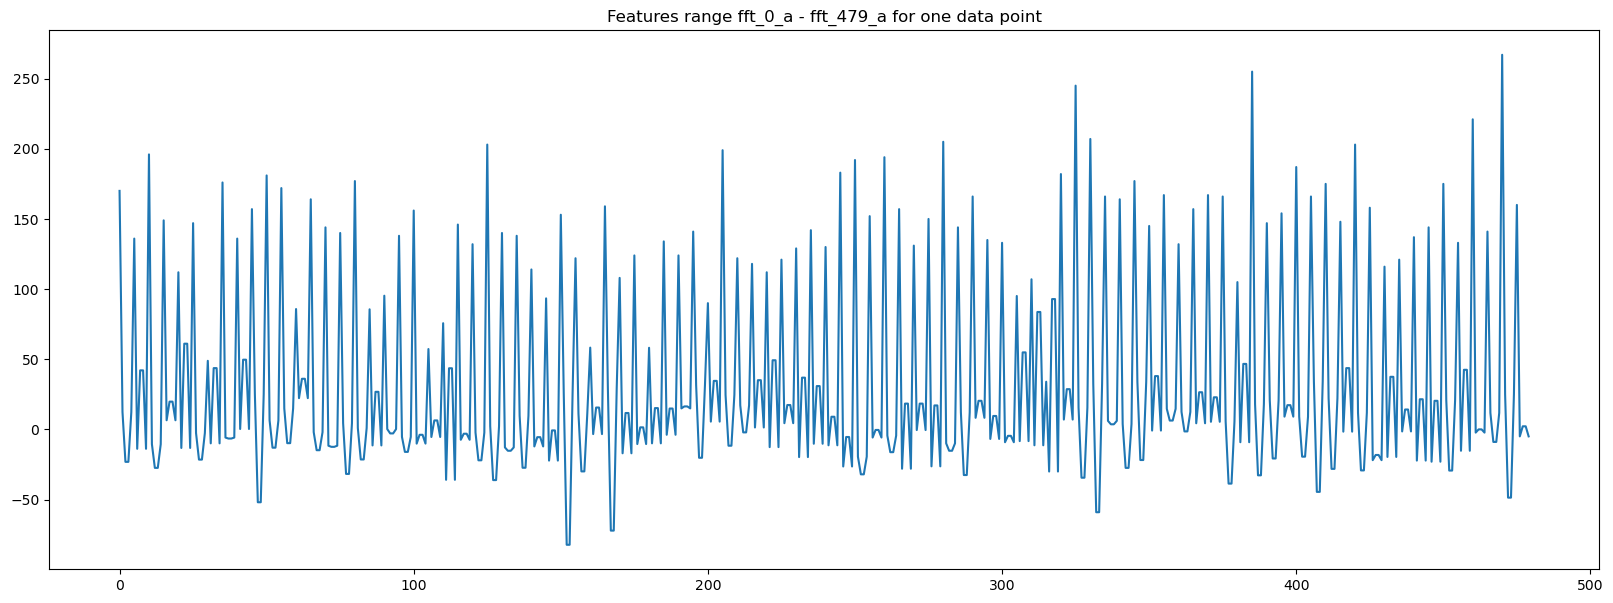

In [9]:
# Sample of data from dataset
sample = data.loc[500, 'fft_0_a':'fft_479_a']

plt.figure(figsize=(20, 7))
plt.plot(range(len(sample)), sample)
plt.title('Features range fft_0_a - fft_479_a for one data point')
plt.show()

## For Images

In [10]:
# class Preprocessing:
    
#     def __init__(self, data, output_dir):
#         self.data = data
#         self.output_dir = output_dir

#     def create_images(self):
#         if not os.path.exists(self.output_dir):
#             os.makedirs(self.output_dir)

#         unique_labels = list(self.data['label'].unique())

#         for label in unique_labels:
#             label_dir = os.path.join(self.output_dir, str(label))
#             os.makedirs(label_dir)

#             label_data = self.data[self.data['label'] == label]

#             for index, row in label_data.iterrows():
#                 sample = row['fft_0_a':'fft_479_a']

#                 plt.figure(figsize=(10, 3))
#                 plt.plot(range(len(sample)), sample)
#                 plt.axis('off')
#                 image_path = os.path.join(label_dir, f"{index}.png")

#                 # Save the figure as an image
#                 plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
#                 plt.close()

#                 # Convert the saved image to grayscale
#                 img = Image.open(image_path).convert('L')
#                 img.save(image_path)

#     def split_data(self, input_dir, train_ratio=0.7, test_ratio=0.15, validation_ratio=0.15):
#         unique_labels = os.listdir(input_dir)

#         for label in unique_labels:
#             if label == '.DS_Store':
#                 continue  # Skip system files
#             label_dir = os.path.join(input_dir, label)
#             train_dir = os.path.join(label_dir, 'train')
#             test_dir = os.path.join(label_dir, 'test')
#             validation_dir = os.path.join(label_dir, 'validation')

#             os.makedirs(train_dir, exist_ok=True)
#             os.makedirs(test_dir, exist_ok=True)
#             os.makedirs(validation_dir, exist_ok=True)

#             images = [f for f in os.listdir(label_dir) if f.endswith('.png')]  # Filter out only .png files
#             random.shuffle(images)

#             total_count = len(images)
#             train_count = int(train_ratio * total_count)
#             test_count = int(test_ratio * total_count)
#             validation_count = total_count - train_count - test_count

#             train_images = images[:train_count]
#             test_images = images[train_count:train_count + test_count]
#             validation_images = images[train_count + test_count:]

#             for image in train_images:
#                 shutil.copy(os.path.join(label_dir, image), os.path.join(train_dir, image))

#             for image in test_images:
#                 shutil.copy(os.path.join(label_dir, image), os.path.join(test_dir, image))

#             for image in validation_images:
#                 shutil.copy(os.path.join(label_dir, image), os.path.join(validation_dir, image))


In [11]:
# prep = Preprocessing(data, 'EEG_images')

In [12]:
# prep.create_images()

In [13]:
# prep.split_data('EEG_images')

## Prepping Data for Analysis

In [14]:
le = LabelEncoder()
data['label']=le.fit_transform(data['label'])

In [15]:
y = data['label']
X = data.drop('label', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=48)

In [16]:
knn_classifier = KNeighborsClassifier(n_neighbors = 3)

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', knn_classifier)])

knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)


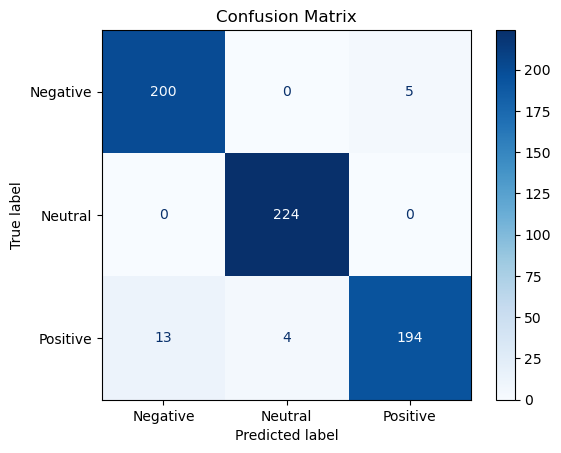

In [17]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [18]:
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall w/ weighted for multiclass labels
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


Accuracy: 0.97
Precision: 0.97
Recall: 0.97


## Principal Component Analysis

In [19]:
pca = PCA(5).fit(data.drop('label', axis=1))
explained_variance = pca.explained_variance_ratio_


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


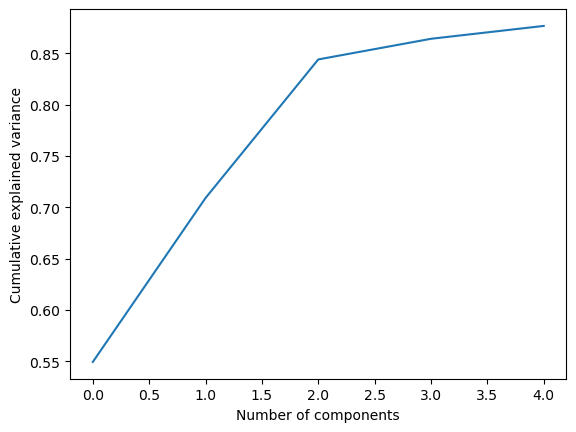

In [20]:
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


In [21]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [22]:
X_train_pca

array([[-4.00508142e+03, -2.50003384e+02, -2.23625868e+02,
        -7.52175953e+00,  2.85620874e+01],
       [ 1.52786947e+03, -7.89878251e+03, -1.93672513e+03,
        -4.57548904e+02,  8.35812851e+01],
       [ 5.49263087e+03,  1.41957784e+03,  3.64692192e+03,
        -4.53775054e+01,  7.28623363e+01],
       ...,
       [ 3.61631947e+03, -7.65891842e+03,  6.26386851e+03,
         1.12699155e+03, -2.82938975e+02],
       [-4.12891849e+03, -3.54064007e+02,  2.67074444e+02,
        -1.07541368e+01, -1.65391867e+01],
       [ 1.00439153e+03,  1.90401743e+03,  4.80952028e+03,
        -7.74618717e+01, -1.29388909e+02]])

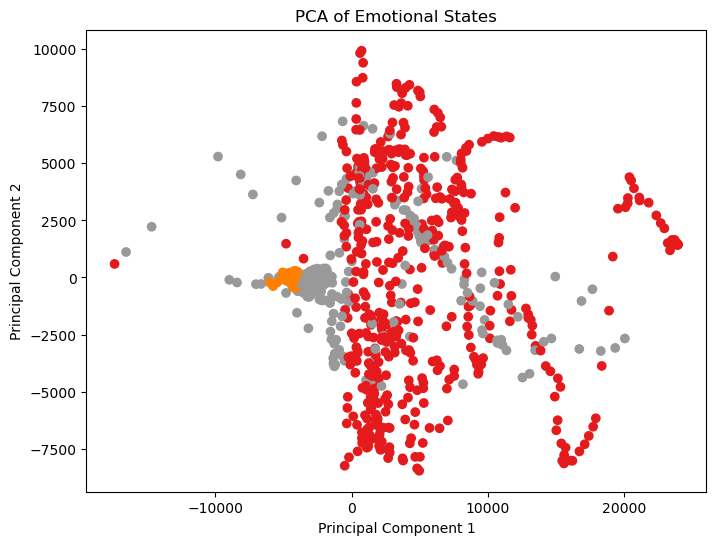

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 2], c=y_train, cmap=plt.cm.Set1)
plt.title("PCA of Emotional States")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [24]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

classification_rep = classification_report(y_test, y_pred, target_names = labels)
print("Classification Report:\n", classification_rep)


Accuracy: 0.946875
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.97      0.95       205
     Neutral       0.96      0.98      0.97       224
    Positive       0.94      0.90      0.92       211

    accuracy                           0.95       640
   macro avg       0.95      0.95      0.95       640
weighted avg       0.95      0.95      0.95       640



## Neural Network

In [25]:
y_train_enc = to_categorical(y_train, 3)
y_test_enc = to_categorical(y_test, 3)

In [26]:
model = keras.Sequential([
    keras.layers.Input(shape=(1500,)),
    keras.layers.Dense(64, activation='relu'), 
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
model.fit(X_train, y_train_enc, epochs = 500, batch_size = 64)

Epoch 1/500
24/24 [==============================] - 1s 2ms/step - loss: 36.1551 - accuracy: 0.7634
Epoch 2/500
24/24 [==============================] - 0s 2ms/step - loss: 13.3845 - accuracy: 0.8566
Epoch 3/500
24/24 [==============================] - 0s 2ms/step - loss: 10.1631 - accuracy: 0.8834
Epoch 4/500
24/24 [==============================] - 0s 2ms/step - loss: 5.5271 - accuracy: 0.8988
Epoch 5/500
24/24 [==============================] - 0s 2ms/step - loss: 6.7765 - accuracy: 0.9115
Epoch 6/500
24/24 [==============================] - 0s 2ms/step - loss: 5.3601 - accuracy: 0.9229
Epoch 7/500
24/24 [==============================] - 0s 2ms/step - loss: 1.9502 - accuracy: 0.9403
Epoch 8/500
24/24 [==============================] - 0s 2ms/step - loss: 1.6356 - accuracy: 0.9363
Epoch 9/500
24/24 [==============================] - 0s 2ms/step - loss: 1.1460 - accuracy: 0.9504
Epoch 10/500
24/24 [==============================] - 0s 2ms/step - loss: 1.8463 - accuracy: 0.9497
Epoch 

24/24 [==============================] - 0s 1ms/step - loss: 3.2004e-07 - accuracy: 1.0000
Epoch 82/500
24/24 [==============================] - 0s 2ms/step - loss: 3.1533e-07 - accuracy: 1.0000
Epoch 83/500
24/24 [==============================] - 0s 2ms/step - loss: 3.0750e-07 - accuracy: 1.0000
Epoch 84/500
24/24 [==============================] - 0s 1ms/step - loss: 3.0199e-07 - accuracy: 1.0000
Epoch 85/500
24/24 [==============================] - 0s 1ms/step - loss: 2.9656e-07 - accuracy: 1.0000
Epoch 86/500
24/24 [==============================] - 0s 2ms/step - loss: 2.9081e-07 - accuracy: 1.0000
Epoch 87/500
24/24 [==============================] - 0s 1ms/step - loss: 2.8697e-07 - accuracy: 1.0000
Epoch 88/500
24/24 [==============================] - 0s 1ms/step - loss: 2.8074e-07 - accuracy: 1.0000
Epoch 89/500
24/24 [==============================] - 0s 2ms/step - loss: 2.7523e-07 - accuracy: 1.0000
Epoch 90/500
24/24 [==============================] - 0s 1ms/step - loss: 2.7

24/24 [==============================] - 0s 1ms/step - loss: 9.2281e-08 - accuracy: 1.0000
Epoch 160/500
24/24 [==============================] - 0s 2ms/step - loss: 9.0843e-08 - accuracy: 1.0000
Epoch 161/500
24/24 [==============================] - 0s 1ms/step - loss: 8.9644e-08 - accuracy: 1.0000
Epoch 162/500
24/24 [==============================] - 0s 1ms/step - loss: 8.8606e-08 - accuracy: 1.0000
Epoch 163/500
24/24 [==============================] - 0s 2ms/step - loss: 8.7407e-08 - accuracy: 1.0000
Epoch 164/500
24/24 [==============================] - 0s 2ms/step - loss: 8.5969e-08 - accuracy: 1.0000
Epoch 165/500
24/24 [==============================] - 0s 2ms/step - loss: 8.4851e-08 - accuracy: 1.0000
Epoch 166/500
24/24 [==============================] - 0s 1ms/step - loss: 8.3732e-08 - accuracy: 1.0000
Epoch 167/500
24/24 [==============================] - 0s 1ms/step - loss: 8.2614e-08 - accuracy: 1.0000
Epoch 168/500
24/24 [==============================] - 0s 1ms/step - 

24/24 [==============================] - 0s 1ms/step - loss: 3.2758e-08 - accuracy: 1.0000
Epoch 238/500
24/24 [==============================] - 0s 1ms/step - loss: 3.2439e-08 - accuracy: 1.0000
Epoch 239/500
24/24 [==============================] - 0s 1ms/step - loss: 3.1879e-08 - accuracy: 1.0000
Epoch 240/500
24/24 [==============================] - 0s 1ms/step - loss: 3.1560e-08 - accuracy: 1.0000
Epoch 241/500
24/24 [==============================] - 0s 1ms/step - loss: 3.1240e-08 - accuracy: 1.0000
Epoch 242/500
24/24 [==============================] - 0s 1ms/step - loss: 3.0841e-08 - accuracy: 1.0000
Epoch 243/500
24/24 [==============================] - 0s 1ms/step - loss: 3.0521e-08 - accuracy: 1.0000
Epoch 244/500
24/24 [==============================] - 0s 1ms/step - loss: 3.0281e-08 - accuracy: 1.0000
Epoch 245/500
24/24 [==============================] - 0s 1ms/step - loss: 2.9722e-08 - accuracy: 1.0000
Epoch 246/500
24/24 [==============================] - 0s 1ms/step - 

24/24 [==============================] - 0s 2ms/step - loss: 1.3423e-08 - accuracy: 1.0000
Epoch 316/500
24/24 [==============================] - 0s 1ms/step - loss: 1.3183e-08 - accuracy: 1.0000
Epoch 317/500
24/24 [==============================] - 0s 1ms/step - loss: 1.2944e-08 - accuracy: 1.0000
Epoch 318/500
24/24 [==============================] - 0s 1ms/step - loss: 1.2784e-08 - accuracy: 1.0000
Epoch 319/500
24/24 [==============================] - 0s 1ms/step - loss: 1.2704e-08 - accuracy: 1.0000
Epoch 320/500
24/24 [==============================] - 0s 1ms/step - loss: 1.2624e-08 - accuracy: 1.0000
Epoch 321/500
24/24 [==============================] - 0s 1ms/step - loss: 1.2384e-08 - accuracy: 1.0000
Epoch 322/500
24/24 [==============================] - 0s 1ms/step - loss: 1.2384e-08 - accuracy: 1.0000
Epoch 323/500
24/24 [==============================] - 0s 1ms/step - loss: 1.2145e-08 - accuracy: 1.0000
Epoch 324/500
24/24 [==============================] - 0s 1ms/step - 

24/24 [==============================] - 0s 2ms/step - loss: 5.8326e-09 - accuracy: 1.0000
Epoch 394/500
24/24 [==============================] - 0s 2ms/step - loss: 5.7527e-09 - accuracy: 1.0000
Epoch 395/500
24/24 [==============================] - 0s 1ms/step - loss: 5.7527e-09 - accuracy: 1.0000
Epoch 396/500
24/24 [==============================] - 0s 1ms/step - loss: 5.6728e-09 - accuracy: 1.0000
Epoch 397/500
24/24 [==============================] - 0s 1ms/step - loss: 5.5929e-09 - accuracy: 1.0000
Epoch 398/500
24/24 [==============================] - 0s 1ms/step - loss: 5.5929e-09 - accuracy: 1.0000
Epoch 399/500
24/24 [==============================] - 0s 1ms/step - loss: 5.5130e-09 - accuracy: 1.0000
Epoch 400/500
24/24 [==============================] - 0s 1ms/step - loss: 5.4331e-09 - accuracy: 1.0000
Epoch 401/500
24/24 [==============================] - 0s 1ms/step - loss: 5.3532e-09 - accuracy: 1.0000
Epoch 402/500
24/24 [==============================] - 0s 2ms/step - 

24/24 [==============================] - 0s 1ms/step - loss: 2.9563e-09 - accuracy: 1.0000
Epoch 472/500
24/24 [==============================] - 0s 1ms/step - loss: 2.9563e-09 - accuracy: 1.0000
Epoch 473/500
24/24 [==============================] - 0s 1ms/step - loss: 2.8764e-09 - accuracy: 1.0000
Epoch 474/500
24/24 [==============================] - 0s 1ms/step - loss: 2.8764e-09 - accuracy: 1.0000
Epoch 475/500
24/24 [==============================] - 0s 1ms/step - loss: 2.7965e-09 - accuracy: 1.0000
Epoch 476/500
24/24 [==============================] - 0s 2ms/step - loss: 2.7965e-09 - accuracy: 1.0000
Epoch 477/500
24/24 [==============================] - 0s 1ms/step - loss: 2.7965e-09 - accuracy: 1.0000
Epoch 478/500
24/24 [==============================] - 0s 1ms/step - loss: 2.7166e-09 - accuracy: 1.0000
Epoch 479/500
24/24 [==============================] - 0s 1ms/step - loss: 2.7166e-09 - accuracy: 1.0000
Epoch 480/500
24/24 [==============================] - 0s 1ms/step - 

In [28]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_enc)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

20/20 [==============================] - 0s 775us/step - loss: 6.2420 - accuracy: 0.9391
Test Loss: 6.2420196533203125
Test Accuracy: 0.9390624761581421


In [29]:
x_pred = model.predict(X_test)

20/20 [==============================] - 0s 765us/step


## 1D Convolutional Network

In [30]:
model2 = keras.Sequential()

model2.add(keras.layers.Conv1D(filters = 64, kernel_size = 3, activation = 'relu', input_shape = (1500, 1)))
model2.add(keras.layers.MaxPooling1D(pool_size=2))
model2.add(keras.layers.Flatten())

# Fully connected (Dense) layers for classification
model2.add(keras.layers.Dense(64, activation='relu'))
model2.add(keras.layers.Dense(3, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1498, 64)          256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 749, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 47936)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                3067968   
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,068,419
Trainable params: 3,068,419
Non-trainable params: 0
____________________________________________

In [31]:
history = model2.fit(X_train, y_train_enc, epochs = 500, batch_size = 64)

Epoch 1/500
24/24 [==============================] - 1s 33ms/step - loss: 378.3919 - accuracy: 0.5214
Epoch 2/500
24/24 [==============================] - 1s 29ms/step - loss: 29.7125 - accuracy: 0.7634
Epoch 3/500
24/24 [==============================] - 1s 29ms/step - loss: 9.3351 - accuracy: 0.8613
Epoch 4/500
24/24 [==============================] - 1s 28ms/step - loss: 11.2866 - accuracy: 0.8673
Epoch 5/500
24/24 [==============================] - 1s 29ms/step - loss: 25.8302 - accuracy: 0.8244
Epoch 6/500
24/24 [==============================] - 1s 28ms/step - loss: 23.8855 - accuracy: 0.8063
Epoch 7/500
24/24 [==============================] - 1s 28ms/step - loss: 5.5117 - accuracy: 0.9189
Epoch 8/500
24/24 [==============================] - 1s 28ms/step - loss: 9.2322 - accuracy: 0.9008
Epoch 9/500
24/24 [==============================] - 1s 30ms/step - loss: 15.7700 - accuracy: 0.8680
Epoch 10/500
24/24 [==============================] - 1s 31ms/step - loss: 2.3371 - accuracy:

24/24 [==============================] - 1s 30ms/step - loss: 9.2645e-06 - accuracy: 1.0000
Epoch 81/500
24/24 [==============================] - 1s 30ms/step - loss: 9.1920e-06 - accuracy: 1.0000
Epoch 82/500
24/24 [==============================] - 1s 29ms/step - loss: 8.9207e-06 - accuracy: 1.0000
Epoch 83/500
24/24 [==============================] - 1s 29ms/step - loss: 8.8430e-06 - accuracy: 1.0000
Epoch 84/500
24/24 [==============================] - 1s 29ms/step - loss: 8.7691e-06 - accuracy: 1.0000
Epoch 85/500
24/24 [==============================] - 1s 29ms/step - loss: 8.6549e-06 - accuracy: 1.0000
Epoch 86/500
24/24 [==============================] - 1s 29ms/step - loss: 8.5002e-06 - accuracy: 1.0000
Epoch 87/500
24/24 [==============================] - 1s 29ms/step - loss: 8.4218e-06 - accuracy: 1.0000
Epoch 88/500
24/24 [==============================] - 1s 29ms/step - loss: 8.3222e-06 - accuracy: 1.0000
Epoch 89/500
24/24 [==============================] - 1s 29ms/step -

24/24 [==============================] - 1s 28ms/step - loss: 3.8164e-06 - accuracy: 1.0000
Epoch 158/500
24/24 [==============================] - 1s 28ms/step - loss: 3.8000e-06 - accuracy: 1.0000
Epoch 159/500
24/24 [==============================] - 1s 28ms/step - loss: 3.7386e-06 - accuracy: 1.0000
Epoch 160/500
24/24 [==============================] - 1s 28ms/step - loss: 3.7328e-06 - accuracy: 1.0000
Epoch 161/500
24/24 [==============================] - 1s 28ms/step - loss: 3.6562e-06 - accuracy: 1.0000
Epoch 162/500
24/24 [==============================] - 1s 28ms/step - loss: 3.6153e-06 - accuracy: 1.0000
Epoch 163/500
24/24 [==============================] - 1s 28ms/step - loss: 3.5578e-06 - accuracy: 1.0000
Epoch 164/500
24/24 [==============================] - 1s 28ms/step - loss: 3.5622e-06 - accuracy: 1.0000
Epoch 165/500
24/24 [==============================] - 1s 28ms/step - loss: 3.4724e-06 - accuracy: 1.0000
Epoch 166/500
24/24 [==============================] - 1s 28

24/24 [==============================] - 1s 28ms/step - loss: 1.7389e-06 - accuracy: 1.0000
Epoch 235/500
24/24 [==============================] - 1s 28ms/step - loss: 1.7430e-06 - accuracy: 1.0000
Epoch 236/500
24/24 [==============================] - 1s 28ms/step - loss: 1.7058e-06 - accuracy: 1.0000
Epoch 237/500
24/24 [==============================] - 1s 28ms/step - loss: 1.6690e-06 - accuracy: 1.0000
Epoch 238/500
24/24 [==============================] - 1s 28ms/step - loss: 1.6653e-06 - accuracy: 1.0000
Epoch 239/500
24/24 [==============================] - 1s 29ms/step - loss: 1.6494e-06 - accuracy: 1.0000
Epoch 240/500
24/24 [==============================] - 1s 29ms/step - loss: 1.6386e-06 - accuracy: 1.0000
Epoch 241/500
24/24 [==============================] - 1s 28ms/step - loss: 1.6082e-06 - accuracy: 1.0000
Epoch 242/500
24/24 [==============================] - 1s 28ms/step - loss: 1.6004e-06 - accuracy: 1.0000
Epoch 243/500
24/24 [==============================] - 1s 28

24/24 [==============================] - 1s 28ms/step - loss: 8.1587e-07 - accuracy: 1.0000
Epoch 312/500
24/24 [==============================] - 1s 28ms/step - loss: 8.0773e-07 - accuracy: 1.0000
Epoch 313/500
24/24 [==============================] - 1s 28ms/step - loss: 8.0860e-07 - accuracy: 1.0000
Epoch 314/500
24/24 [==============================] - 1s 28ms/step - loss: 7.9750e-07 - accuracy: 1.0000
Epoch 315/500
24/24 [==============================] - 1s 28ms/step - loss: 7.9231e-07 - accuracy: 1.0000
Epoch 316/500
24/24 [==============================] - 1s 28ms/step - loss: 7.8017e-07 - accuracy: 1.0000
Epoch 317/500
24/24 [==============================] - 1s 28ms/step - loss: 7.7242e-07 - accuracy: 1.0000
Epoch 318/500
24/24 [==============================] - 1s 28ms/step - loss: 7.6283e-07 - accuracy: 1.0000
Epoch 319/500
24/24 [==============================] - 1s 39ms/step - loss: 7.5500e-07 - accuracy: 1.0000
Epoch 320/500
24/24 [==============================] - 1s 28

24/24 [==============================] - 1s 27ms/step - loss: 3.8335e-07 - accuracy: 1.0000
Epoch 389/500
24/24 [==============================] - 1s 27ms/step - loss: 3.8494e-07 - accuracy: 1.0000
Epoch 390/500
24/24 [==============================] - 1s 27ms/step - loss: 3.8047e-07 - accuracy: 1.0000
Epoch 391/500
24/24 [==============================] - 1s 27ms/step - loss: 3.7096e-07 - accuracy: 1.0000
Epoch 392/500
24/24 [==============================] - 1s 27ms/step - loss: 3.6769e-07 - accuracy: 1.0000
Epoch 393/500
24/24 [==============================] - 1s 27ms/step - loss: 3.6577e-07 - accuracy: 1.0000
Epoch 394/500
24/24 [==============================] - 1s 27ms/step - loss: 3.6585e-07 - accuracy: 1.0000
Epoch 395/500
24/24 [==============================] - 1s 27ms/step - loss: 3.5706e-07 - accuracy: 1.0000
Epoch 396/500
24/24 [==============================] - 1s 27ms/step - loss: 3.5386e-07 - accuracy: 1.0000
Epoch 397/500
24/24 [==============================] - 1s 27

24/24 [==============================] - 1s 30ms/step - loss: 1.7466e-07 - accuracy: 1.0000
Epoch 466/500
24/24 [==============================] - 1s 30ms/step - loss: 1.6858e-07 - accuracy: 1.0000
Epoch 467/500
24/24 [==============================] - 1s 30ms/step - loss: 1.6739e-07 - accuracy: 1.0000
Epoch 468/500
24/24 [==============================] - 1s 30ms/step - loss: 1.6731e-07 - accuracy: 1.0000
Epoch 469/500
24/24 [==============================] - 1s 29ms/step - loss: 1.6499e-07 - accuracy: 1.0000
Epoch 470/500
24/24 [==============================] - 1s 30ms/step - loss: 1.6235e-07 - accuracy: 1.0000
Epoch 471/500
24/24 [==============================] - 1s 30ms/step - loss: 1.6219e-07 - accuracy: 1.0000
Epoch 472/500
24/24 [==============================] - 1s 30ms/step - loss: 1.6044e-07 - accuracy: 1.0000
Epoch 473/500
24/24 [==============================] - 1s 29ms/step - loss: 1.5700e-07 - accuracy: 1.0000
Epoch 474/500
24/24 [==============================] - 1s 29

In [32]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test_enc)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

20/20 [==============================] - 0s 5ms/step - loss: 11.8468 - accuracy: 0.9375
Test Loss: 11.846796989440918
Test Accuracy: 0.9375


# Mental State Raw EEG Dataset

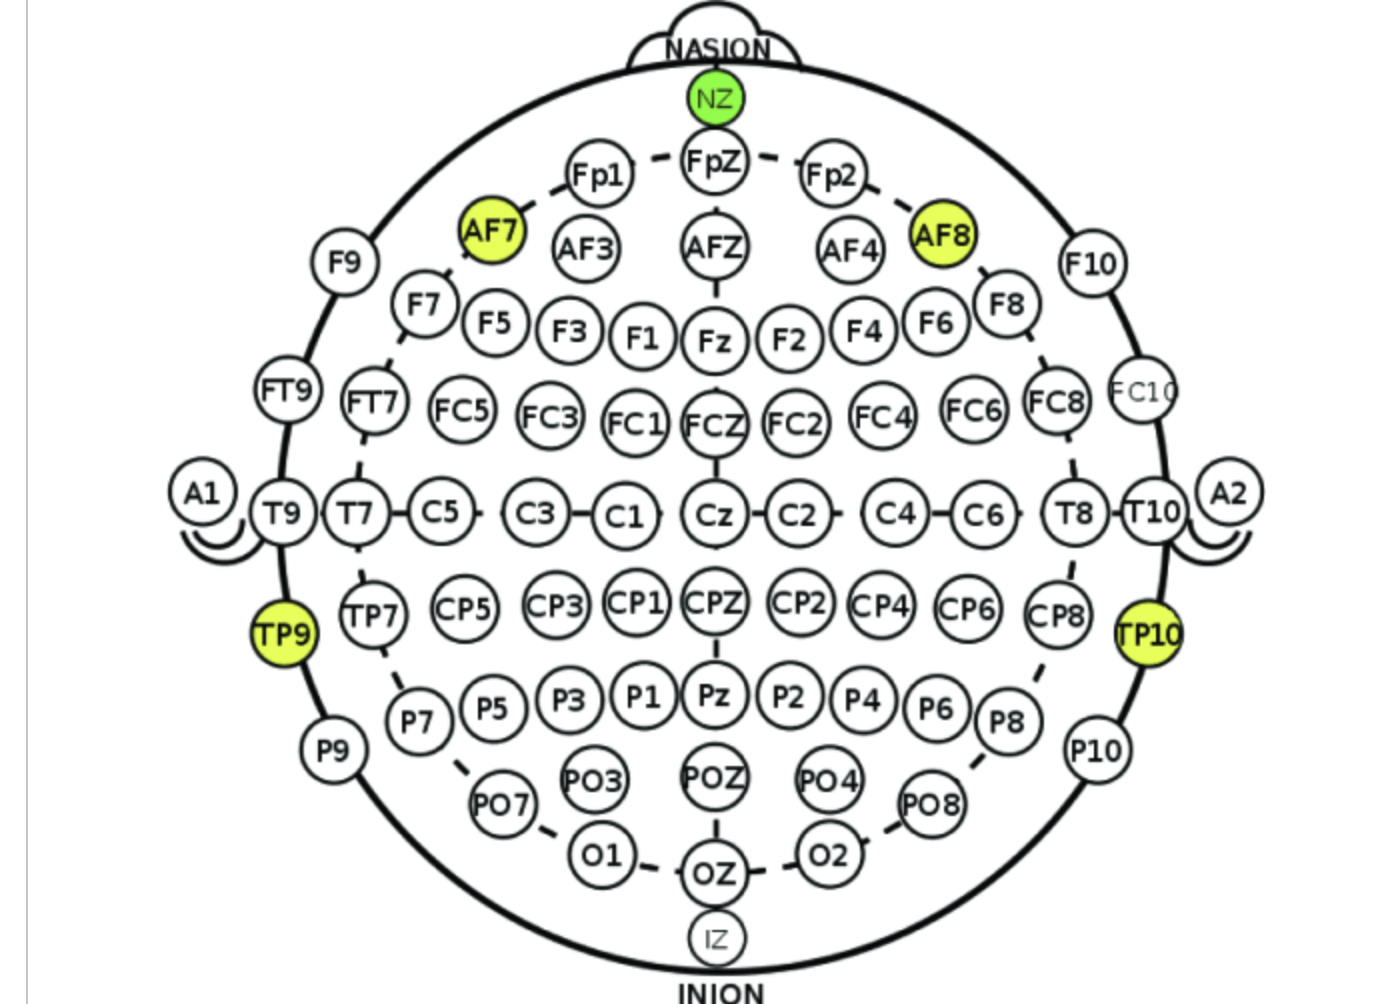

In [33]:
conca1 = pd.read_csv('mental_state_dataset/subjecta-concentrating-1.csv')
conca1.head()

timestamps     TP9     AF7      AF8    TP10  Right AUX
0  1.533223e+09  59.105  28.320   15.137  12.207     54.199
1  1.533223e+09  62.012  30.273   43.945  11.719     79.102
2  1.533223e+09  44.922  30.273  -97.656  11.230     32.715
3  1.533223e+09  28.809  27.832 -110.352   9.277     29.785
4  1.533223e+09  36.156  28.809  -73.242  11.230     50.781

In [34]:
conca2 = pd.read_csv('mental_state_dataset/subjecta-concentrating-2.csv')
conca2.head()

timestamps     TP9     AF7      AF8    TP10  Right AUX
0  1.533223e+09  -6.348  51.758  -24.414   4.395     -9.277
1  1.533223e+09 -12.207  55.664  -65.918   3.906    -27.832
2  1.533223e+09   1.953  49.805   61.523   8.789     11.719
3  1.533223e+09  20.508  54.688  159.180  19.531     67.871
4  1.533223e+09  24.902  59.570  117.188  26.855     72.754

In [35]:
concb1 = pd.read_csv('mental_state_dataset/subjectb-concentrating-1.csv')
concb1.head()

timestamps     TP9     AF7      AF8    TP10  Right AUX
0  1.533223e+09  41.992  38.574  137.695  33.691      6.348
1  1.533223e+09  38.574  41.504 -190.430  31.738    -27.832
2  1.533223e+09  30.273  39.062 -338.867  24.902    -33.203
3  1.533223e+09  34.668  35.645 -124.023  26.367     21.973
4  1.533223e+09  42.969  36.621   21.973  30.762     62.988

In [36]:
concb2 = pd.read_csv('mental_state_dataset/subjectb-concentrating-2.csv')
concb2.head()

timestamps     TP9     AF7      AF8   TP10  Right AUX
0  1.533223e+09  23.438  36.621  419.434  3.906     -6.836
1  1.533223e+09  13.672  38.086  -59.082  1.953     -6.836
2  1.533223e+09  22.949  37.598 -229.980  3.906    -12.207
3  1.533223e+09  44.922  36.621   62.012  3.906    -28.320
4  1.533223e+09  59.570  40.039  457.031  6.348     -8.789

In [37]:
concc1 = pd.read_csv('mental_state_dataset/subjectc-concentrating-1.csv')
concc1.head()

timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.533045e+09  22.461  83.008  11.230  24.414     77.148
1  1.533045e+09  16.602  27.344   3.906  18.066     86.914
2  1.533045e+09  12.695 -43.945   1.953   6.348      3.906
3  1.533045e+09   1.953  -3.418   8.789  -0.488      1.465
4  1.533045e+09  16.113  24.902   8.301   8.301     25.879

In [38]:
concc2 = pd.read_csv('mental_state_dataset/subjectc-concentrating-2.csv')
concc2.head()

timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.533045e+09  17.090  21.484  21.484  14.160     19.043
1  1.533045e+09  32.227 -12.695  16.602  17.090    -38.574
2  1.533045e+09  36.621  23.438  16.113  21.973     14.160
3  1.533045e+09  30.762  72.266  19.531  26.367      2.441
4  1.533045e+09  24.414  38.574  21.973  27.832    -34.180

In [39]:
concd1 = pd.read_csv('mental_state_dataset/subjectd-concentrating-1.csv')
concd1.head()

timestamps     TP9     AF7      AF8    TP10  Right AUX
0  1.533223e+09  11.719  25.879 -240.234  24.902     70.801
1  1.533223e+09   9.766  24.414 -465.820  18.555     64.941
2  1.533223e+09  13.672  29.785 -401.367  10.254     33.691
3  1.533223e+09  15.625  30.762 -125.488   9.277     70.312
4  1.533223e+09   8.301  29.297 -204.590   7.812     97.656

In [40]:
concd2 = pd.read_csv('mental_state_dataset/subjectd-concentrating-2.csv')
concd2.head()

timestamps     TP9     AF7      AF8    TP10  Right AUX
0  1.533223e+09  55.664   1.465 -362.793  31.250     26.855
1  1.533223e+09  52.246   5.859 -116.211  30.762     49.316
2  1.533223e+09  47.852  10.254 -412.598  29.297     52.246
3  1.533223e+09  37.109   8.301 -788.086  31.738     -9.766
4  1.533223e+09  43.945   3.906 -815.430  25.879    -60.059

In [41]:
neuta1 = pd.read_csv('mental_state_dataset/subjecta-neutral-1.csv')
neuta1.head()

timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.533058e+09   4.883  22.949   8.789  23.926     35.156
1  1.533058e+09  19.531  22.461   5.371  28.320     66.406
2  1.533058e+09  20.508  19.531  11.230  25.391     33.691
3  1.533058e+09  30.273  14.160  21.484  37.109    -31.250
4  1.533058e+09  24.902  22.461  16.602  38.086     32.715

In [42]:
neuta2 = pd.read_csv('mental_state_dataset/subjecta-neutral-2.csv')
neuta2.head()

timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.533058e+09  13.672  35.645  32.227   5.371     25.391
1  1.533058e+09  21.484  30.762  24.902  14.160     15.137
2  1.533058e+09  33.203  29.785  29.297  19.043     20.996
3  1.533058e+09  24.902  29.785  31.250  19.531     28.320
4  1.533058e+09  16.113  32.227  27.832  19.531     14.160

In [43]:
neutb1 = pd.read_csv('mental_state_dataset/subjectb-neutral-1.csv')
neutb1.head()

timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.533058e+09  45.410  41.016  65.430  41.504     23.926
1  1.533058e+09  25.391  42.480  72.266  31.250     28.320
2  1.533058e+09  20.996  41.016  77.637  33.691     55.176
3  1.533058e+09  35.645  40.527  76.172  28.320     36.133
4  1.533058e+09  39.551  37.109  74.707  39.062     -7.324

In [44]:
neutb2 = pd.read_csv('mental_state_dataset/subjectb-neutral-2.csv')
neutb2.head()

timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.533058e+09  35.645  30.273  38.086  40.527     76.660
1  1.533058e+09  36.133  34.180  31.250  39.551     12.695
2  1.533058e+09  16.602  29.297  35.645  18.555    -41.016
3  1.533058e+09  19.531  24.414  38.086  13.184    -23.438
4  1.533058e+09  37.598  31.738  30.762  24.414    -33.691

In [45]:
neutc1 = pd.read_csv('mental_state_dataset/subjectc-neutral-1.csv')
neutc1.head()

timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.533057e+09  40.527  39.062  10.742  31.738     49.316
1  1.533057e+09  39.062  33.691   1.465  36.133     33.691
2  1.533057e+09  29.297  35.645  -2.930  31.250      9.766
3  1.533057e+09  22.461  40.039  -7.812  22.949     58.105
4  1.533057e+09  23.926  36.133   0.488  18.555     58.594

In [46]:
neutc2 = pd.read_csv('mental_state_dataset/subjectc-neutral-2.csv')
neutc2.head()

timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.533057e+09  22.461  43.457 -33.691  22.461     10.254
1  1.533057e+09  35.645  45.410  -8.789  29.785     16.602
2  1.533057e+09  49.316  47.363  29.785  47.852     35.645
3  1.533057e+09  33.691  46.387  11.719  49.316     50.293
4  1.533057e+09  18.066  44.434 -19.531  35.645     38.086

In [47]:
neutd1 = pd.read_csv('mental_state_dataset/subjectd-neutral-1.csv')
neutd1.head()

timestamps     TP9     AF7     AF8   TP10  Right AUX
0  1.533058e+09  53.223  23.926  14.160  0.977      4.883
1  1.533058e+09  45.410  20.996  14.160  5.371     35.156
2  1.533058e+09  34.180  19.043   5.371  4.395     64.941
3  1.533058e+09  28.320  18.066  -7.812  1.953     29.785
4  1.533058e+09  35.645  19.531   2.930  1.953     -7.812

In [48]:
neutd2 = pd.read_csv('mental_state_dataset/subjectd-neutral-2.csv')
neutd2.head()

timestamps     TP9    AF7     AF8    TP10  Right AUX
0  1.533058e+09  -1.465  6.836  12.695 -77.148     33.691
1  1.533058e+09   8.301  6.348  -2.930 -81.055    -18.555
2  1.533058e+09  20.996  7.812   0.488 -75.195     24.902
3  1.533058e+09  20.508  6.836  16.113 -64.453     65.430
4  1.533058e+09  11.719  9.766  10.742 -62.988     76.172

In [49]:
relaxa1 = pd.read_csv('mental_state_dataset/subjecta-relaxed-1.csv')
relaxa1.head()

timestamps     TP9     AF7     AF8   TP10  Right AUX
0  1.533059e+09  30.762  15.625  29.785  0.977      0.977
1  1.533059e+09  26.367  13.672  28.320  0.000     39.551
2  1.533059e+09  21.484  14.160  28.320  2.930     39.551
3  1.533059e+09  11.719  15.625  26.367  0.977     74.219
4  1.533059e+09  17.578  16.113  22.461 -1.465     91.309

In [50]:
relaxa2 = pd.read_csv('mental_state_dataset/subjecta-relaxed-2.csv')
relaxa2.head()

timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.533060e+09   9.766  19.531  21.484 -42.969     47.852
1  1.533060e+09  23.926  15.137  22.949 -39.062      0.000
2  1.533060e+09  47.852  17.578  21.973 -35.645     28.809
3  1.533060e+09  38.574  22.461  14.648 -39.062     77.637
4  1.533060e+09  20.996  26.367  12.207 -39.551     62.012

In [51]:
relaxb1 = pd.read_csv('mental_state_dataset/subjectb-relaxed-1.csv')
relaxb1.head()

timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.533060e+09  43.457  39.551  48.828  19.043     75.684
1  1.533060e+09  57.617  40.039  48.340  23.438     44.434
2  1.533060e+09  41.504  41.016  47.852  25.879     14.648
3  1.533060e+09  26.855  39.551  49.316  24.414     49.316
4  1.533060e+09  20.020  38.086  49.805  22.461     18.066

In [52]:
relaxb2 = pd.read_csv('mental_state_dataset/subjectb-relaxed-2.csv')
relaxb2.head()

timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.533061e+09  20.996  23.926  29.297  20.020     62.012
1  1.533061e+09  40.039  22.949  28.809  21.973     53.223
2  1.533061e+09  48.340  24.902  31.250  28.320     33.691
3  1.533061e+09  29.297  24.414  33.203  27.832     36.621
4  1.533061e+09  16.113  25.879  27.344  20.996     67.871

In [53]:
relaxc1 = pd.read_csv('mental_state_dataset/subjectc-relaxed-1.csv')
relaxc1.head()

timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.533044e+09  20.508  12.207  25.391  11.230     15.137
1  1.533044e+09  -1.465  15.625  35.156  -0.488     -2.930
2  1.533044e+09  -0.977  15.625  36.133   4.883    -24.414
3  1.533044e+09  25.879  15.625  34.180   4.883      6.836
4  1.533044e+09  31.738  16.113  27.344   9.766     32.715

In [54]:
relaxc2 = pd.read_csv('mental_state_dataset/subjectc-relaxed-2.csv')
relaxc2.head()

timestamps     TP9     AF7    AF8   TP10  Right AUX
0  1.533045e+09  18.066  11.719 -4.395 -4.883    -48.340
1  1.533045e+09  33.691  20.996  2.441  1.953     19.531
2  1.533045e+09  24.902  21.973  6.836  5.859     40.039
3  1.533045e+09  13.672  15.625  5.859  3.906     18.066
4  1.533045e+09   6.836  12.695  2.441 -1.465     10.742

In [55]:
relaxd1 = pd.read_csv('mental_state_dataset/subjectd-relaxed-1.csv')
relaxd1.head()

timestamps     TP9     AF7     AF8   TP10  Right AUX
0  1.533054e+09 -14.648  28.809  33.203  0.000     58.594
1  1.533054e+09  -9.277  27.344  29.297 -0.488     36.133
2  1.533054e+09 -11.719  28.320  28.320  0.000     18.066
3  1.533054e+09 -15.625  28.809  32.227  6.836     26.855
4  1.533054e+09 -10.254  28.809  27.832  4.883     38.086

In [56]:
relaxd2 = pd.read_csv('mental_state_dataset/subjectd-relaxed-2.csv')
relaxd2.head()

timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.533057e+09  43.457  25.391  52.734   9.277    -38.574
1  1.533057e+09  30.273  24.414  55.176  11.719    -18.066
2  1.533057e+09   6.836  26.367  45.410   4.395     17.578
3  1.533057e+09 -16.602  31.738  38.086 -12.207     22.461
4  1.533057e+09  -1.465  28.320  47.363 -17.578     89.355

### Separating Signals for Feature Extraction

In [57]:
class EEGSignalExtractor:
    
    def __init__(self, eeg_dataframe):
        self.eeg_channels = eeg_dataframe.iloc[:, 1:].values
        self.eeg_signals = [self.eeg_channels[:, i] for i in range(self.eeg_channels.shape[1])]

    def separate_signals(self):
        TP9 = self.eeg_signals[0]
        AF7 = self.eeg_signals[1]
        AF8 = self.eeg_signals[2]
        TP10 = self.eeg_signals[3]
        RAUX = self.eeg_signals[4]
        return TP9, AF7, AF8, TP10, RAUX


In [58]:
class STFTAnalyzer:
    
    def __init__(self, eeg_signal, fs = 500):
        self.eeg_signal = eeg_signal
        self.fs = fs

    def stft(self):
        f, t, Sxx = spectrogram(self.eeg_signal, fs=self.fs)
        return f, t, 10 * np.log10(Sxx)


In [59]:
def extract_stft(eeg_dataframe, fs = 500):
    extractor = EEGSignalExtractor(eeg_dataframe)
    TP9, AF7, AF8, TP10, RAUX = extractor.separate_signals()
    
    electrodes = ['TP9', 'AF7', 'AF8', 'TP10', 'RAUX']
    analyzers = [STFTAnalyzer(signal, fs) for signal in [TP9, AF7, AF8, TP10, RAUX]]
    
    results = []
    for i, analyzer in enumerate(analyzers):
        f, t, stft_result = analyzer.stft()
        electrode_name = electrodes[i]
        results.append((f, t, stft_result, electrode_name))
    
    return results

def plot_stft_results(stft_results):
    fig, axes = plt.subplots(5, 1, figsize=(10, 12))
    
    for i, result in enumerate(stft_results):
        f, t, stft_result, electrode_name = result
        ax = axes[i]
        ax.pcolormesh(t, f, stft_result)
        ax.set_title(f"Electrode {electrode_name}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()
    

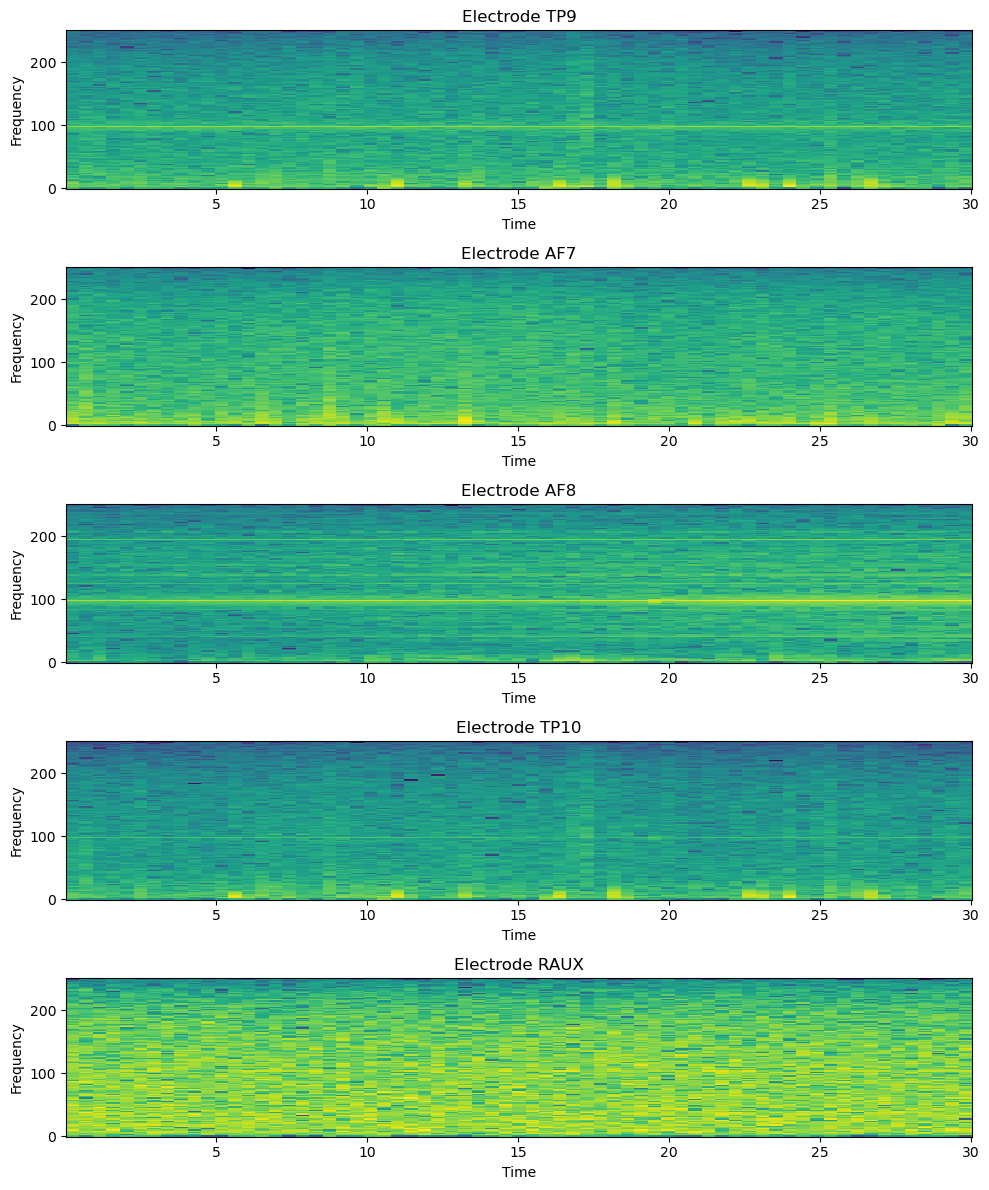

In [60]:
conca1_signals = conca1

conca1_stft = extract_stft(conca1_signals)
plot_stft_results(conca1_stft)

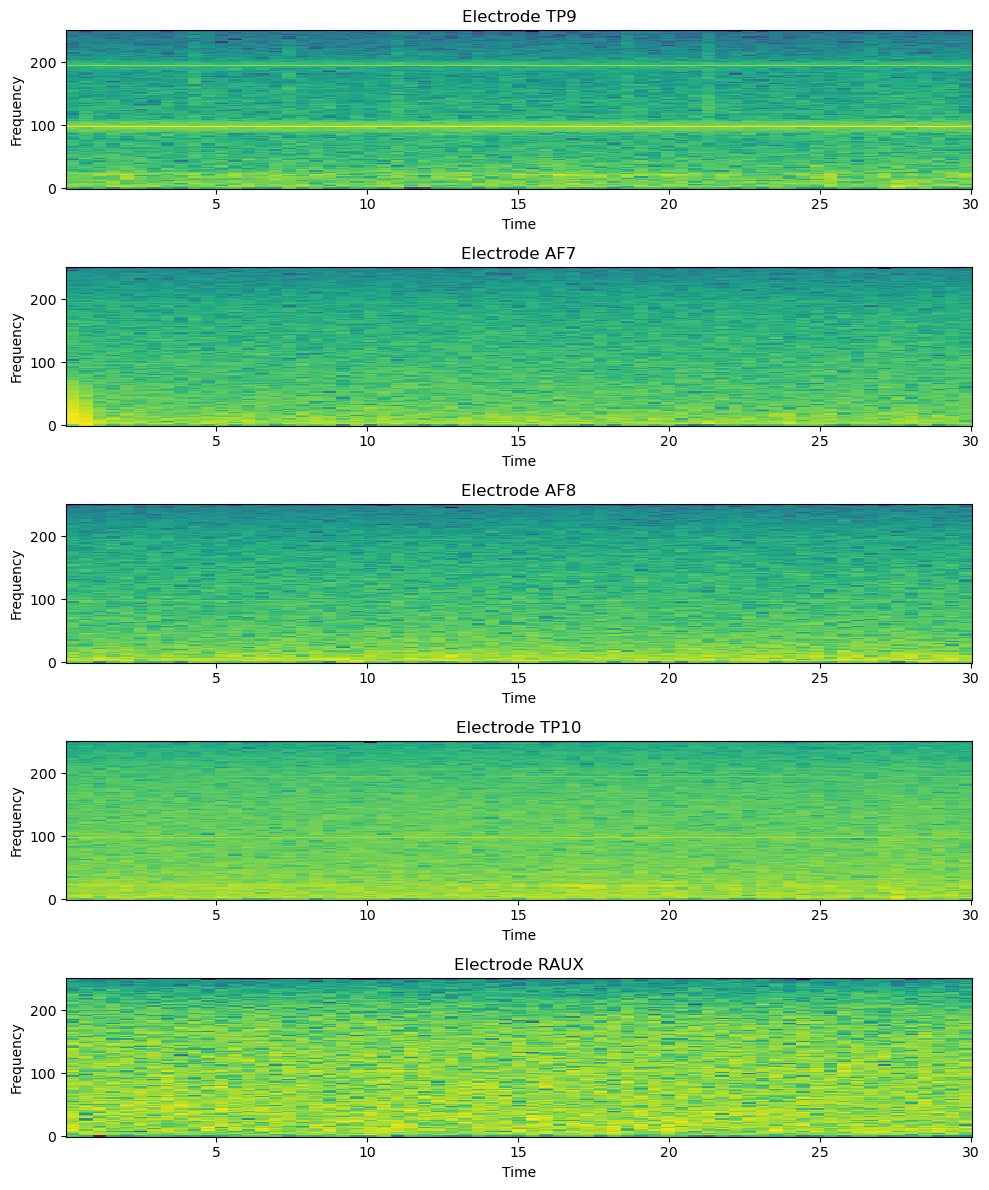

In [61]:
relaxa2_signals = relaxa2

relaxa2_stft = extract_stft(relaxa2_signals)
plot_stft_results(relaxa2_stft)

In [62]:
class HFDAnalyzer:
    
    def __init__(self, eeg_signal, fs = 500):
        self.eeg_signal = eeg_signal
        self.fs = fs

    def hfd(self):
        results = pyeeg.hfd(self.eeg_signal, Kmax=5)
        return results

def extract_hfd(eeg_dataframe, fs = 500):
    extractor = EEGSignalExtractor(eeg_dataframe)
    TP9, AF7, AF8, TP10, RAUX = extractor.separate_signals()

    analyzers = [HFDAnalyzer(signal, fs) for signal in [TP9, AF7, AF8, TP10, RAUX]]
    electrode_names = ["TP9", "AF7", "AF8", "TP10", "RAUX"]

    hfd_results = []
    for i, analyzer in enumerate(analyzers):
        hfd_result = analyzer.hfd()
        hfd_results.append((hfd_result, electrode_names[i]))

    return hfd_results

In [63]:
conca1_signals = conca1

conca1_hfd = extract_hfd(conca1_signals)
conca1_hfd

[(0.7700169049321912, 'TP9'),
 (0.6249708158545375, 'AF7'),
 (0.8556073316063213, 'AF8'),
 (0.6022813958600078, 'TP10'),
 (0.7852475670354101, 'RAUX')]

## Segment Extractor

In [64]:
# class EEGSegmentExtractor:
    
#     def __init__(self, eeg_dataframe, dataframe_name, num_segments = 100):
#         self.eeg_dataframe = eeg_dataframe
#         self.num_segments = num_segments
#         self.dataframe_name = dataframe_name

#     def segment_signals(self):
#         electrode_names = self.eeg_dataframe.columns[1:]
#         segments = []

#         for electrode_name in electrode_names:
#             electrode_signal = self.eeg_dataframe[electrode_name].values
#             segment_length = len(electrode_signal) // self.num_segments

#             for i in range(self.num_segments):
#                 segment_data = electrode_signal[i * segment_length : (i + 1) * segment_length]
#                 segments.append((self.dataframe_name, electrode_name, segment_data))

#         return segments

#     def set_dataframe_name(self, electrode_name):
#         if electrode_name.startswith('conc'):
#             return 'Concentrated'
#         elif electrode_name.startswith('neut'):
#             return 'Neutral'
#         elif electrode_name.startswith('relax'):
#             return 'Relaxed'
#         else:
#             return 'Unknown'
    
#     def extract_features(self):
#         fft_full_features = self.extract_fft_features_f()
#         fft_half_features = self.extract_fft_features_h()
#         fft_fifth_features = self.extract_fft_features_q()
#         mean_features = self.extract_mean_features()
#         std_features = self.extract_stddev_features()
#         min_features = self.extract_min_features()
#         max_features = self.extract_max_features()

#         combined_features = pd.concat([fft_full_features, fft_half_features, fft_fifth_features, 
#                                        mean_features, std_features, min_features, max_features], axis=1)

#         electrode_names = [electrode_name for _, electrode_name, _ in self.segment_signals()]
#         dataframe_names = [self.set_dataframe_name(self.dataframe_name)] * len(electrode_names)

#         combined_features['electrode'] = electrode_names
#         combined_features['target'] = dataframe_names

#         return combined_features

#     def extract_mean_features(self):
#         features = []

#         for _, _, segment_data in self.segment_signals():
#             mean = np.mean(segment_data)
#             features.append(mean)

#         combined_features_mean = pd.DataFrame(features, columns=['mean'])

#         return combined_features_mean


#     def extract_stddev_features(self):
#         features = []

#         for _, _, segment_data in self.segment_signals():
#             std_dev = np.std(segment_data, ddof=1)
#             features.append(std_dev)

#         combined_features_std = pd.DataFrame(features, columns=['std'])

#         return combined_features_std


#     def extract_max_features(self):
#         features = []

#         for _, _, segment_data in self.segment_signals():
#             max_val = np.max(segment_data)
#             features.append(max_val)

#         combined_features_max = pd.DataFrame(features, columns=['max'])

#         return combined_features_max

#     def extract_min_features(self):
#         features = []

#         for _, _, segment_data in self.segment_signals():
#             min_val = np.min(segment_data)
#             features.append(min_val)

#         combined_features_min = pd.DataFrame(features, columns=['min'])

#         return combined_features_min

#     def extract_fft_features_f(self):
#         return self.extract_fft_features(self.num_segments)

#     def extract_fft_features_h(self):
#         half_segments = self.num_segments // 2
#         return self.extract_fft_features(half_segments)
    
#     def extract_fft_features_q(self):
#         fifth_segments = self.num_segments // 5
#         return self.extract_fft_features(fifth_segments)

#     def extract_fft_features(self, num_segments):
#         features = []

#         for _, _, segment_data in self.segment_signals(num_segments):
#             n = len(segment_data)
#             uS = 1.0  # Unit sampling rate
#             fft_values = np.abs(np.fft.fft(segment_data, axis=0))[0:n // 2] * 2 / n
#             freqs = np.linspace(0.0, 1.0 / (2.0 * uS), n // 2)

#             ntop = 30
#             top_indices = np.argsort(fft_values, axis=0)[:, :ntop]
#             top_freqs = freqs[top_indices].flatten()

#             features.append(top_freqs)

#         feature_names_fft = [f'fft_{i + 1}' for i in range(ntop)]
#         combined_features_fft = pd.DataFrame(features, columns=feature_names_fft)

#         return combined_features_fft

# def extract_entropy_features(self):
#         features = []

#         for _, _, segment_data in self.segment_signals():
#             segment_entropy = entropy(segment_data, base=2)
#             features.append(segment_entropy)

#         combined_features_entropy = pd.DataFrame(features, columns=['entropy'])

#         return combined_features_entropy
 

In [341]:
class EEGSegmentExtractor:
    
    def __init__(self, eeg_dataframe, dataframe_name, num_segments = 100, ntop = 30):
        self.eeg_dataframe = eeg_dataframe
        self.num_segments = num_segments
        self.dataframe_name = dataframe_name
        self.ntop = ntop

    def segment_signals(self, num_segments = None):
        if num_segments is None:
            num_segments = self.num_segments

        electrode_names = self.eeg_dataframe.columns[1:]
        segments = []

        for electrode_name in electrode_names:
            electrode_signal = self.eeg_dataframe[electrode_name].values
            segment_length = len(electrode_signal) // num_segments

            for i in range(num_segments):
                segment_data = electrode_signal[i * segment_length : (i + 1) * segment_length]
                segments.append((self.dataframe_name, electrode_name, segment_data))

        return segments

    def set_dataframe_name(self, electrode_name):
        if electrode_name.startswith('conc'):
            return 'Concentrated'
        elif electrode_name.startswith('neut'):
            return 'Neutral'
        elif electrode_name.startswith('relax'):
            return 'Relaxed'
        else:
            return 'Unknown'
    
    def extract_features(self):
        fft_full_features = self.extract_fft_features(self.num_segments)
        fft_half_features = self.extract_fft_features(self.num_segments // 2)
        fft_fifth_features = self.extract_fft_features(self.num_segments // 5)
        fft_seventh_features = self.extract_fft_features(self.num_segments // 7) # Added on the second iteration
        mean_features = self.extract_mean_features()
        std_features = self.extract_stddev_features()
        min_features = self.extract_min_features()
        max_features = self.extract_max_features()

        fft_half_feature_names = [f'fft_half_{i + 1}' for i in range(self.ntop)]
        fft_fifth_feature_names = [f'fft_fifth_{i + 1}' for i in range(self.ntop)]
        fft_seventh_feature_names = [f'fft_seventh_{i + 1}' for i in range(self.ntop)]

        fft_half_features = pd.concat([fft_half_features], axis=1)
        fft_half_features.columns = fft_half_feature_names

        fft_fifth_features = pd.concat([fft_fifth_features], axis=1)
        fft_fifth_features.columns = fft_fifth_feature_names
        
        fft_seventh_features = pd.concat([fft_seventh_features], axis=1)
        fft_seventh_features.columns = fft_seventh_feature_names

        combined_features = pd.concat([fft_full_features, fft_half_features, fft_fifth_features, 
                                       fft_seventh_features, mean_features, std_features, 
                                       min_features, max_features], axis=1)

        electrode_names = [electrode_name for _, electrode_name, _ in self.segment_signals()]
        dataframe_names = [self.set_dataframe_name(self.dataframe_name)] * len(electrode_names)

        combined_features['electrode'] = electrode_names
        combined_features['target'] = dataframe_names

        return combined_features

    def extract_mean_features(self):
        features = []

        for _, _, segment_data in self.segment_signals():
            mean = np.mean(segment_data)
            features.append(mean)

        combined_features_mean = pd.DataFrame(features, columns=['mean'])

        return combined_features_mean

    def extract_stddev_features(self):
        features = []

        for _, _, segment_data in self.segment_signals():
            std_dev = np.std(segment_data, ddof=1)
            features.append(std_dev)

        combined_features_std = pd.DataFrame(features, columns=['std'])

        return combined_features_std

    def extract_max_features(self):
        features = []

        for _, _, segment_data in self.segment_signals():
            max_val = np.max(segment_data)
            features.append(max_val)

        combined_features_max = pd.DataFrame(features, columns=['max'])

        return combined_features_max

    def extract_min_features(self):
        features = []

        for _, _, segment_data in self.segment_signals():
            min_val = np.min(segment_data)
            features.append(min_val)

        combined_features_min = pd.DataFrame(features, columns=['min'])

        return combined_features_min

    def extract_fft_features(self, num_segments):
        features = []

        for _, _, segment_data in self.segment_signals(num_segments):
            n = len(segment_data)
            uS = 1.0  # Unit sampling rate
            fft_values = np.abs(np.fft.fft(segment_data))[0:n // 2] * 2 / n
            freqs = np.linspace(0.0, 1.0 / (2.0 * uS), n // 2)

            # ntop = 30
            top_indices = np.argsort(fft_values)[:self.ntop]
            top_freqs = freqs[top_indices].flatten()

            features.append(top_freqs)

        feature_names_fft = [f'fft_{i + 1}' for i in range(self.ntop)]
        combined_features_fft = pd.DataFrame(features, columns=feature_names_fft)

        return combined_features_fft


In [342]:
conca1_extractor = EEGSegmentExtractor(conca1, "conca1")
conca1_segments = conca1_extractor.segment_signals()
features1 = conca1_extractor.extract_features()

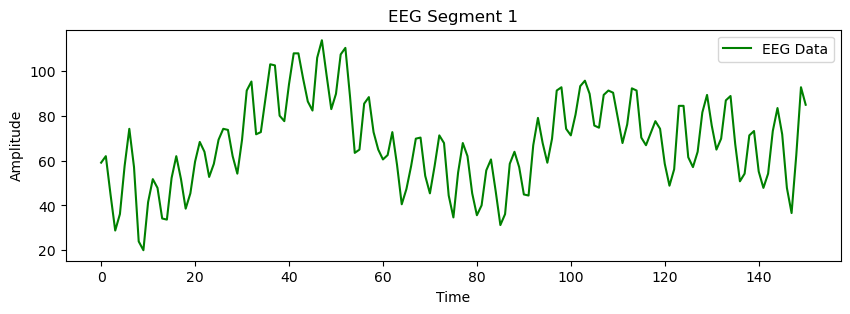

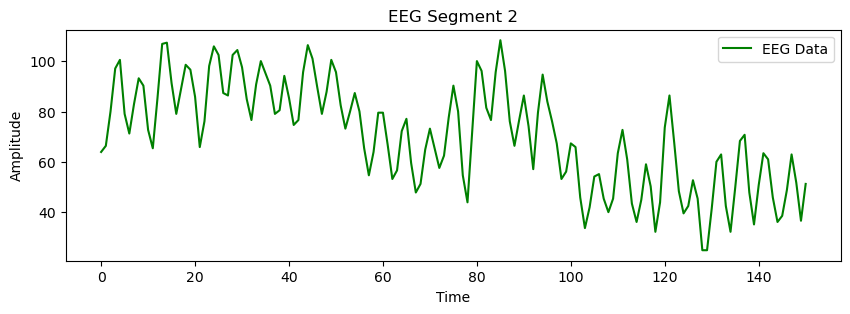

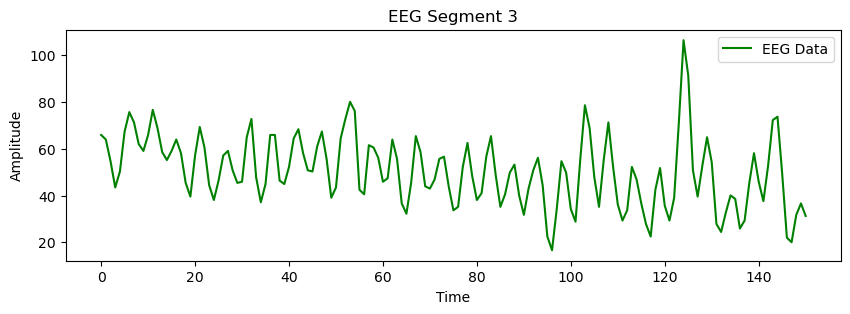

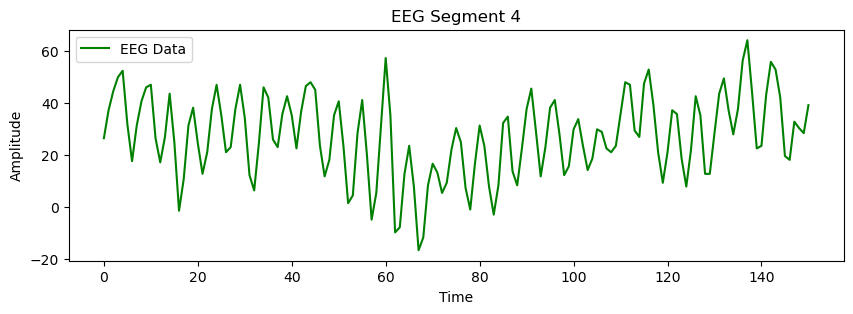

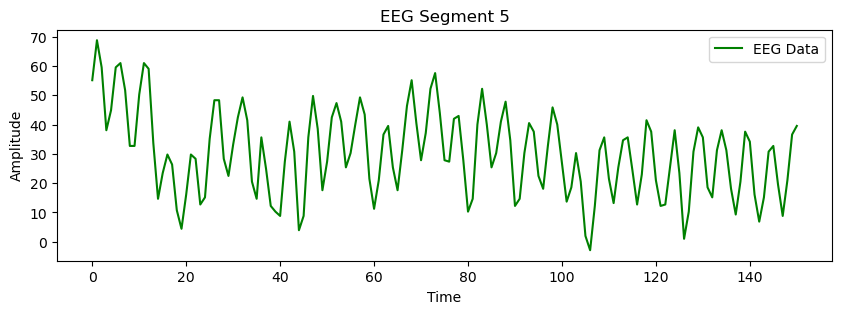

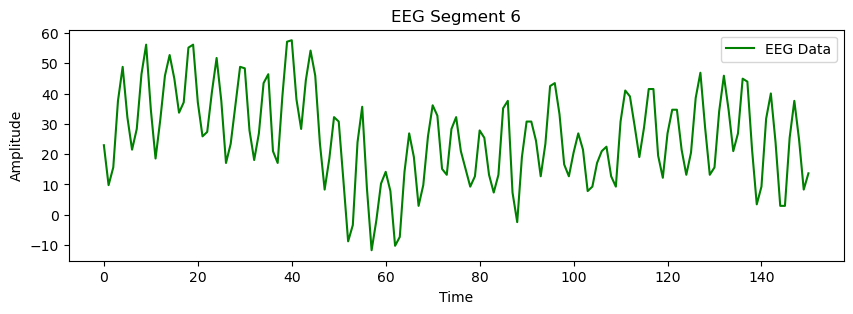

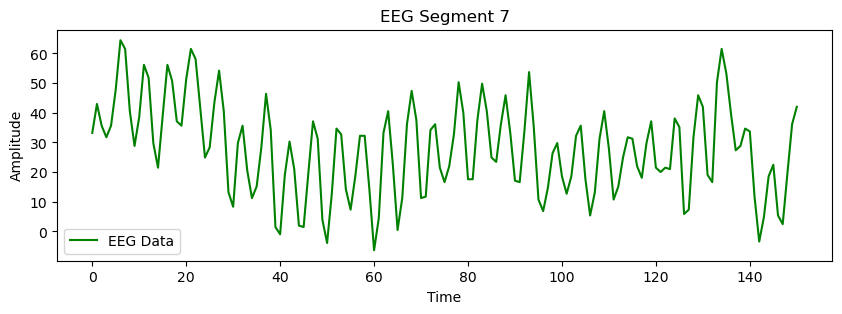

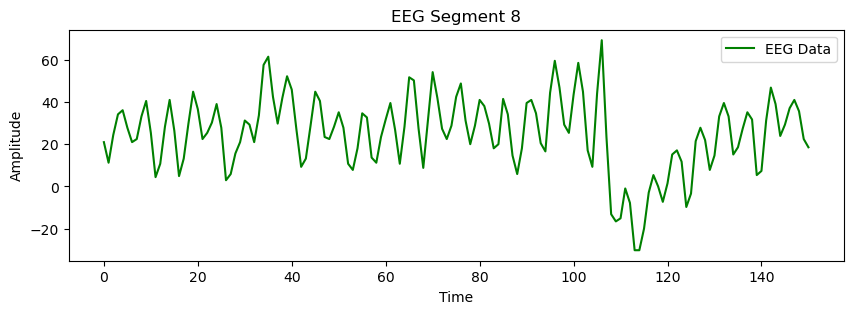

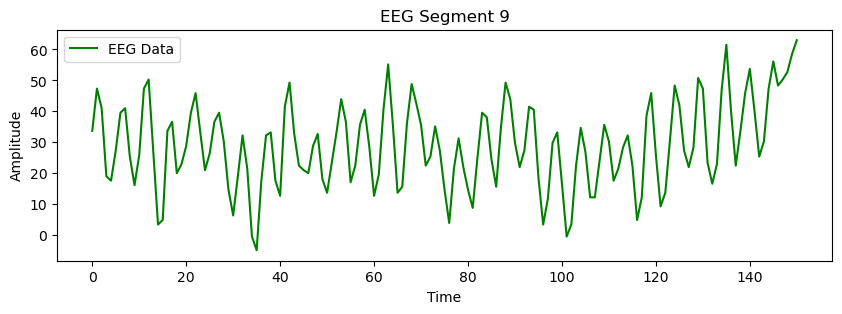

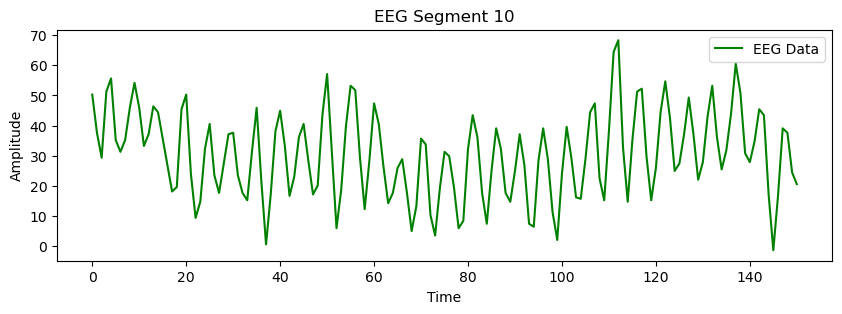

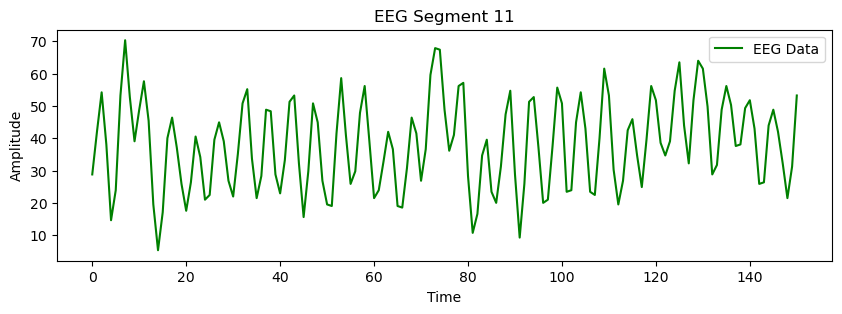

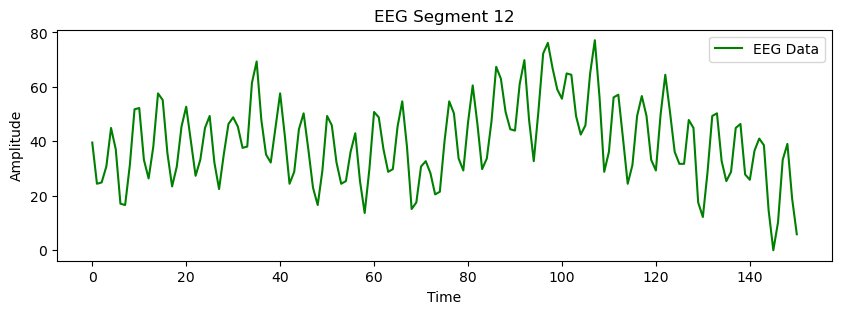

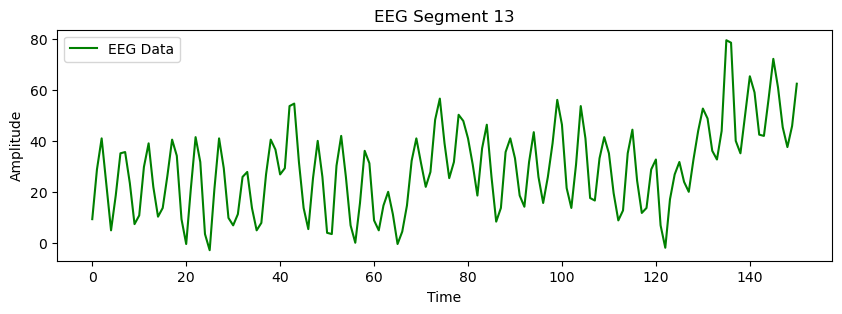

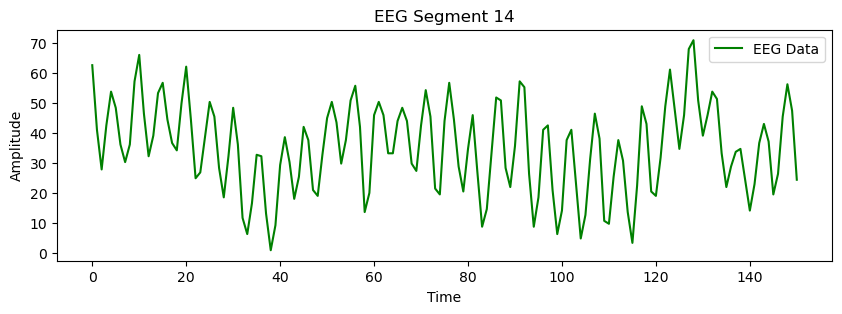

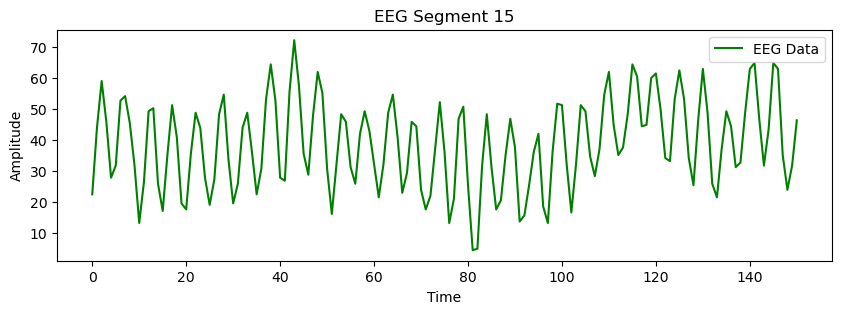

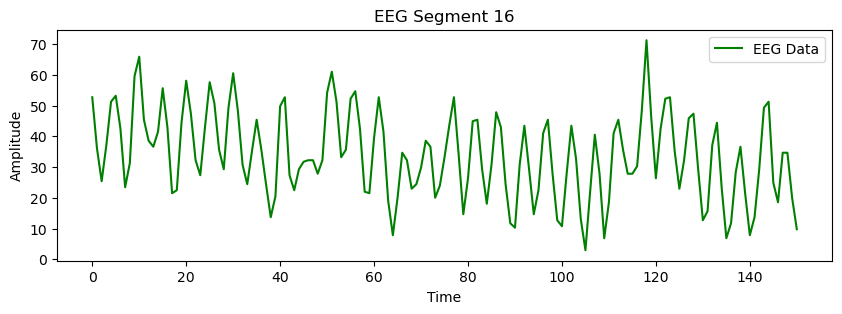

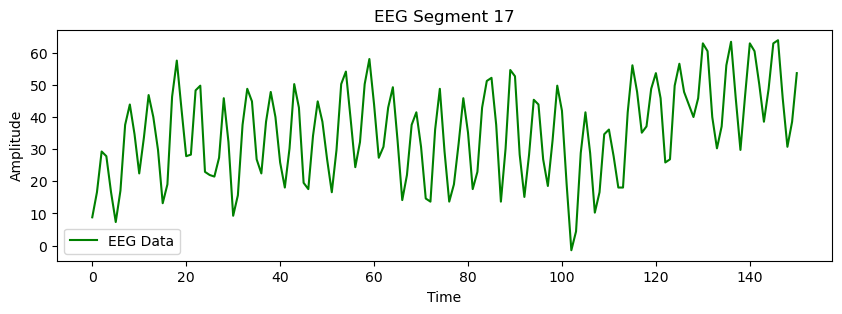

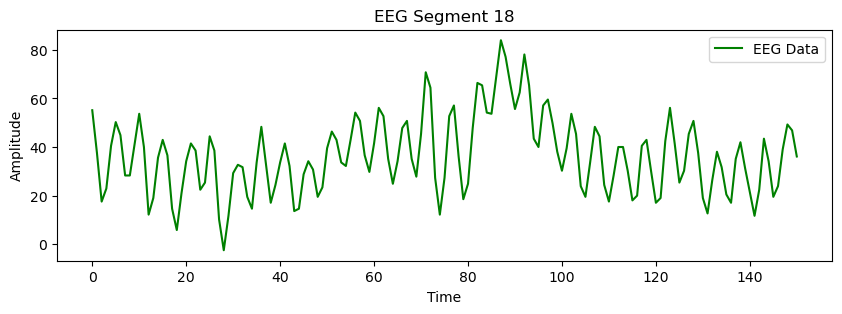

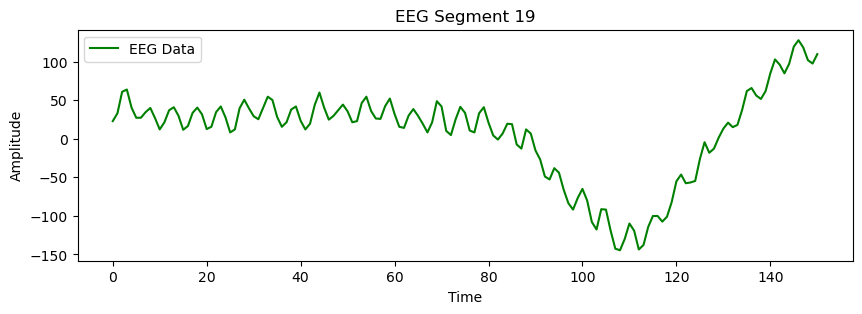

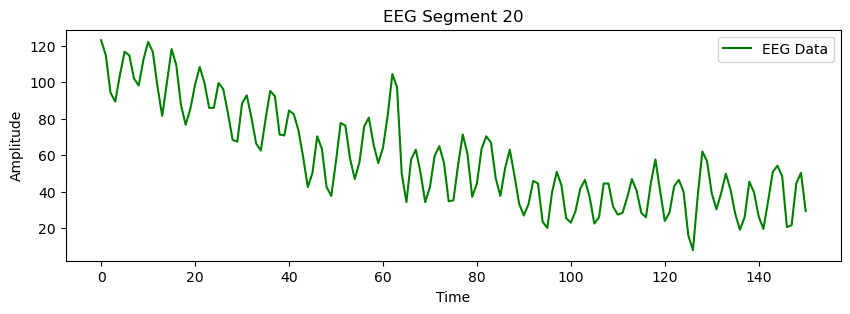

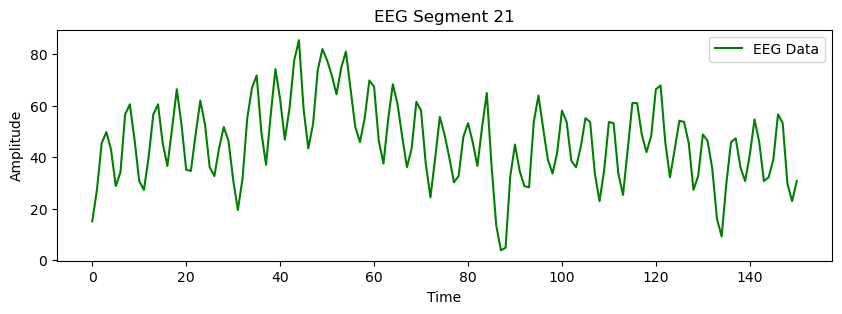

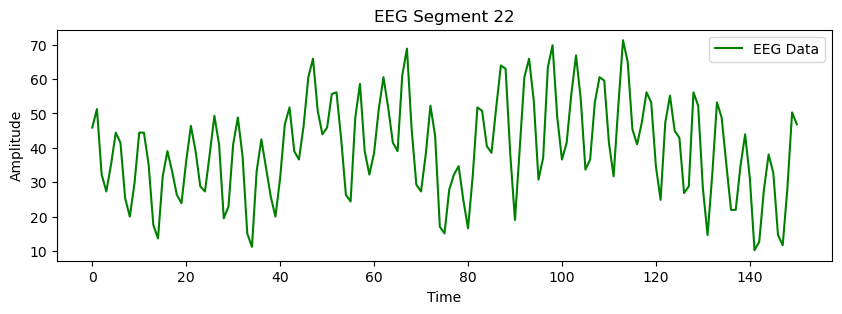

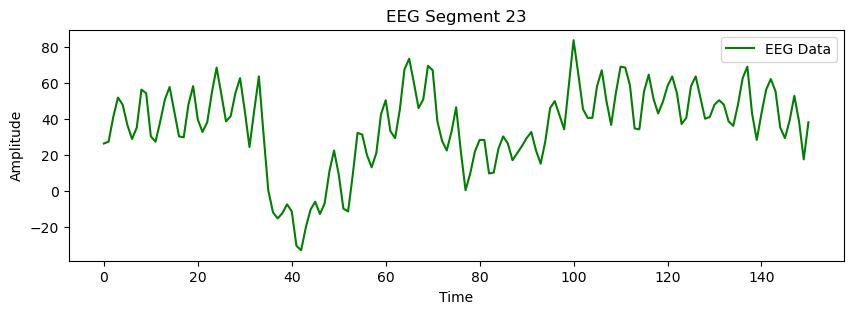

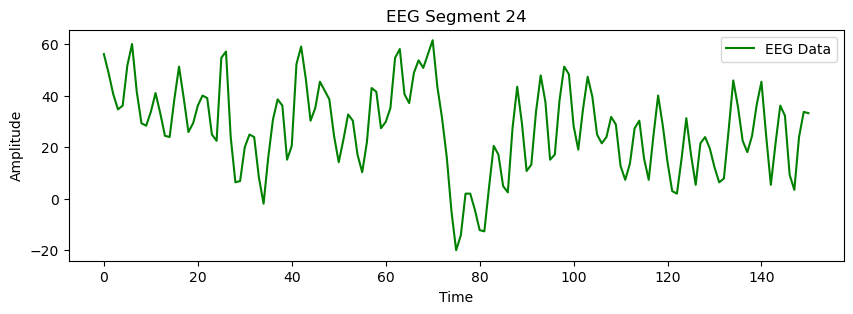

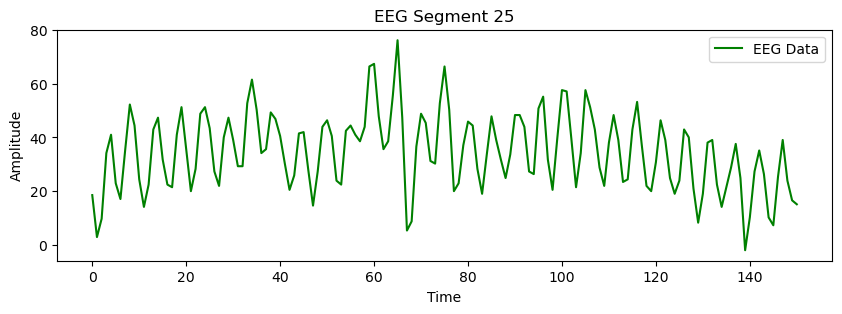

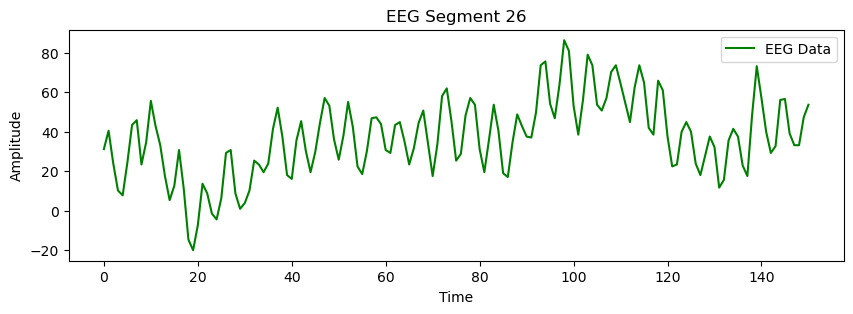

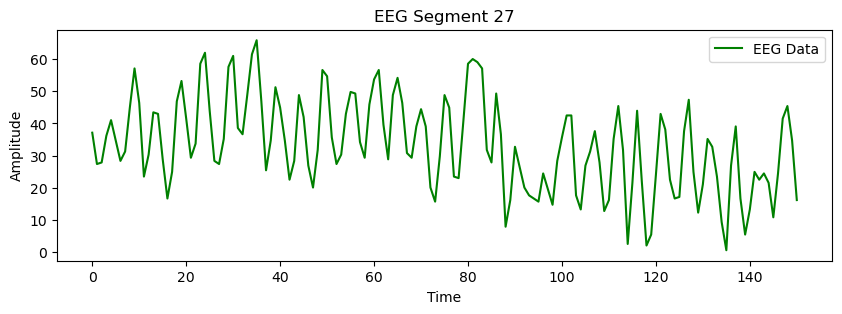

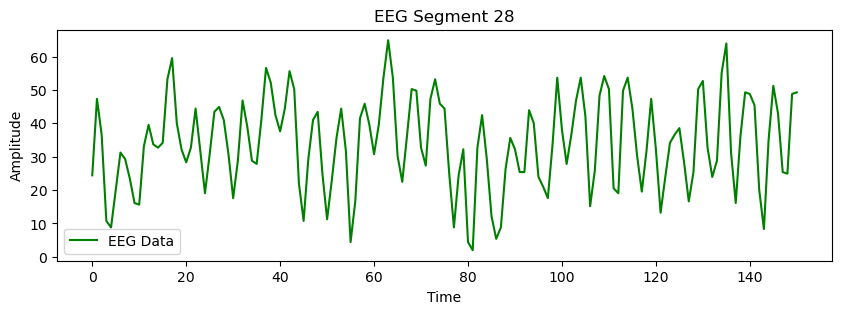

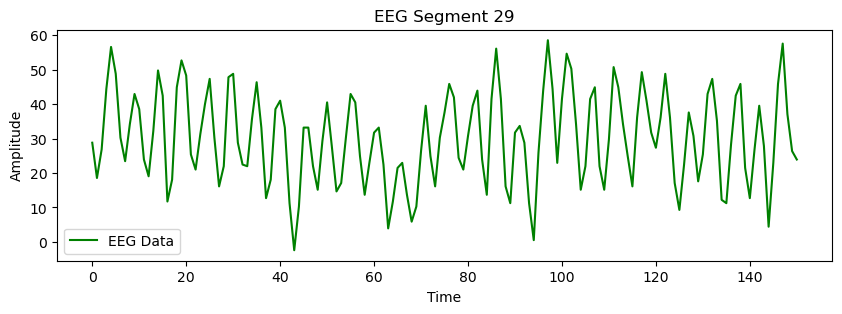

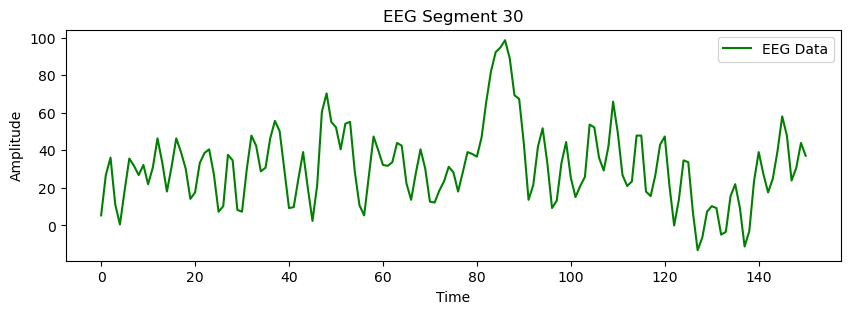

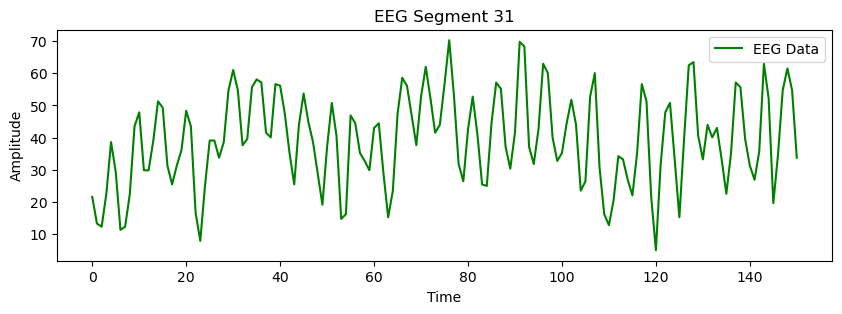

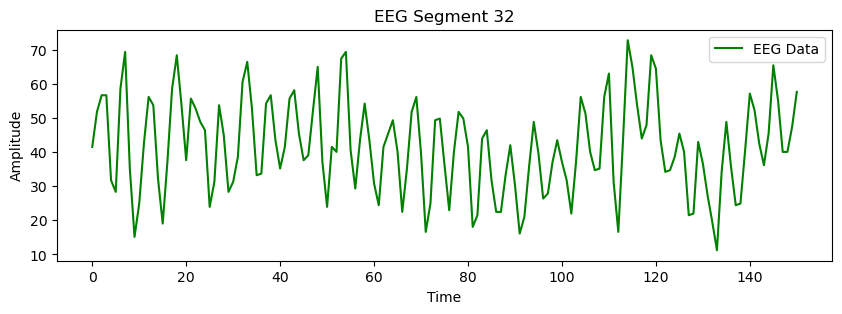

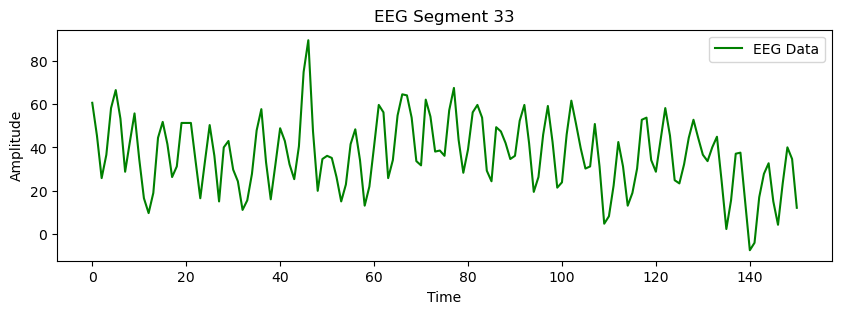

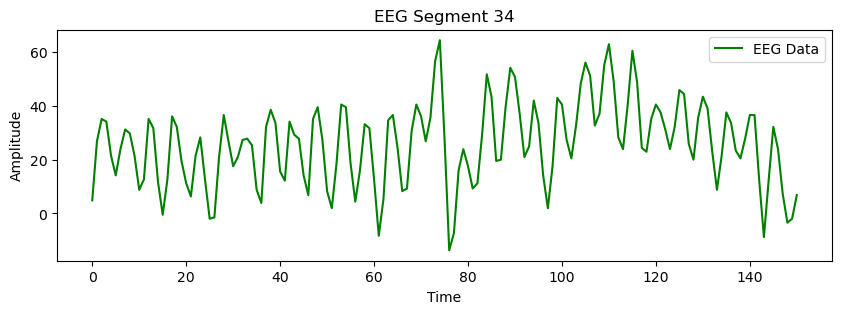

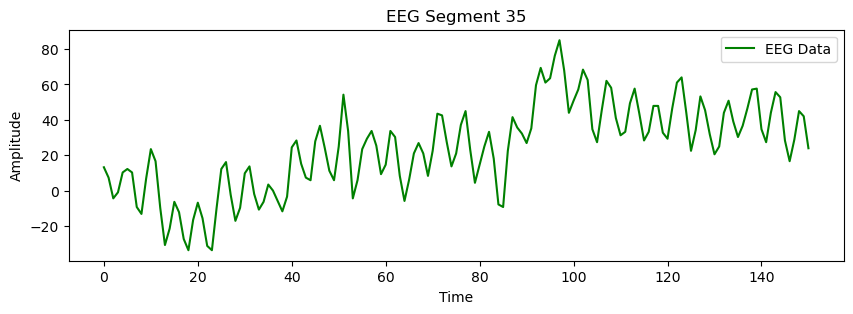

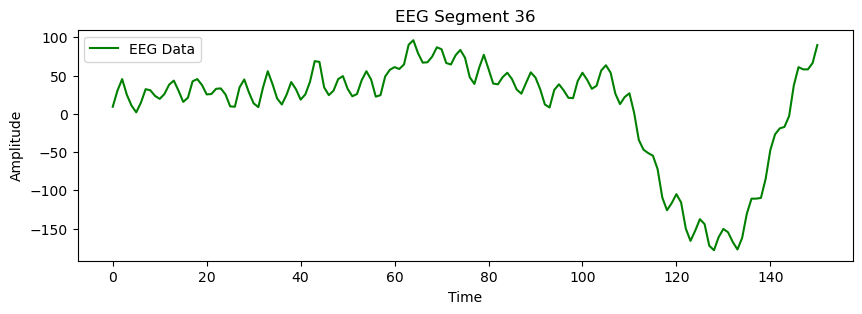

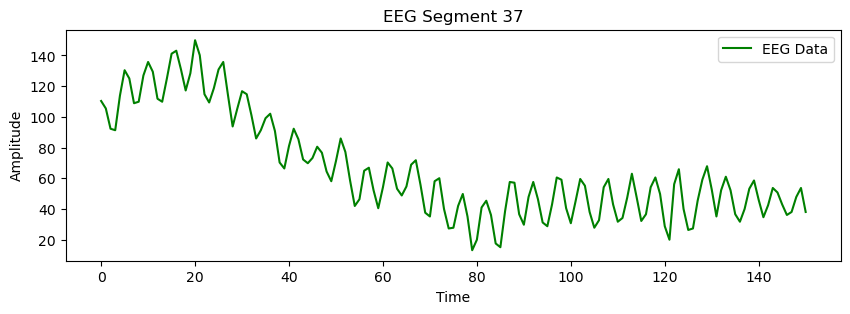

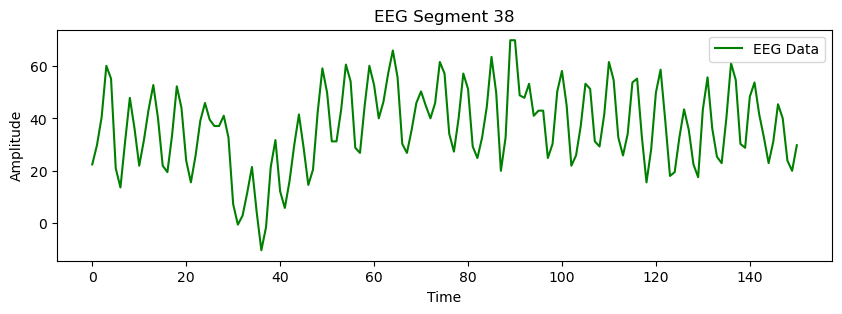

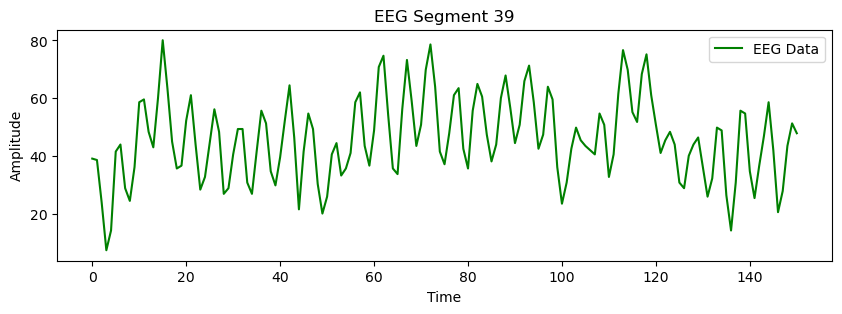

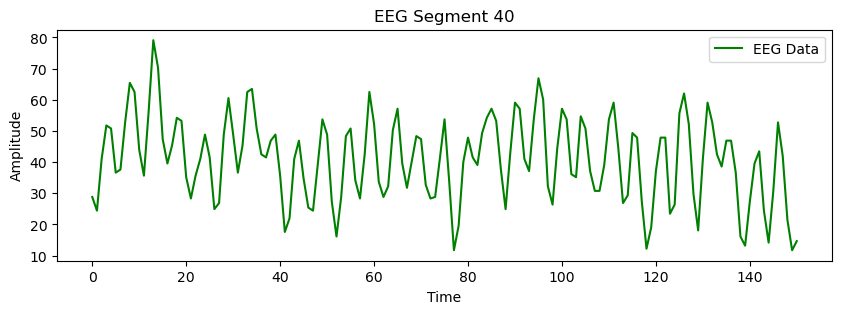

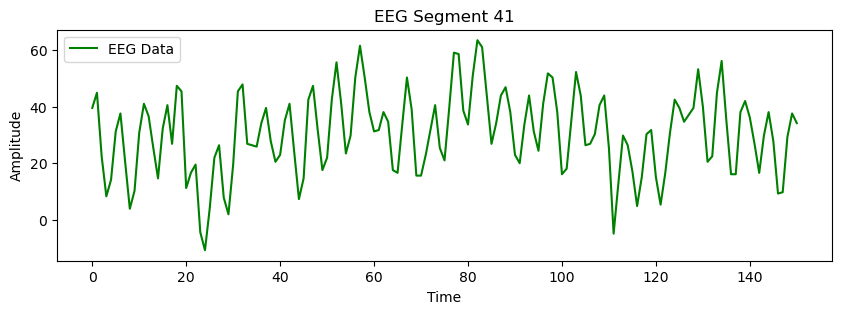

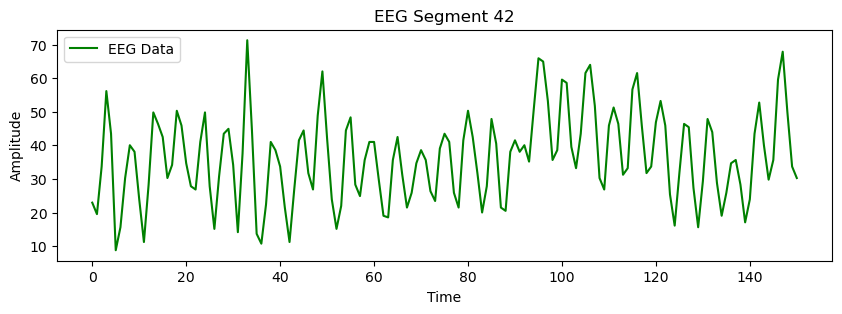

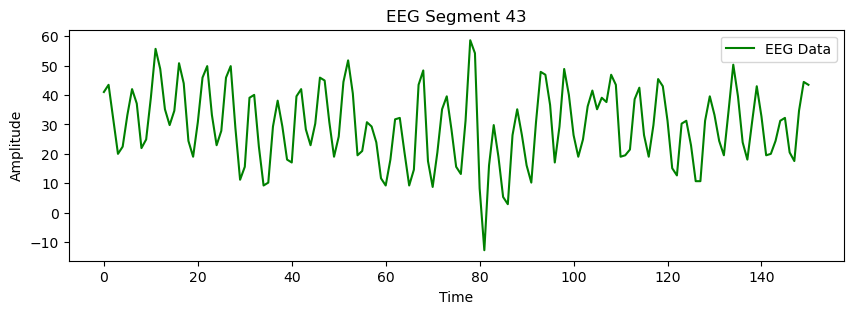

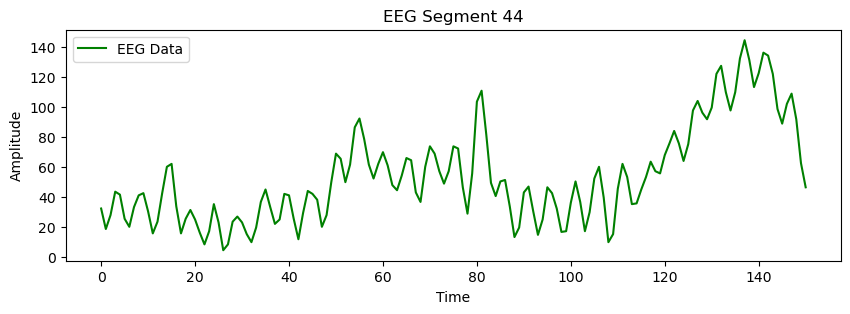

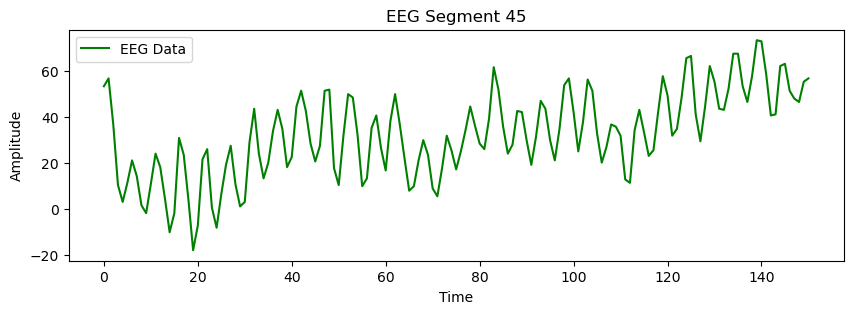

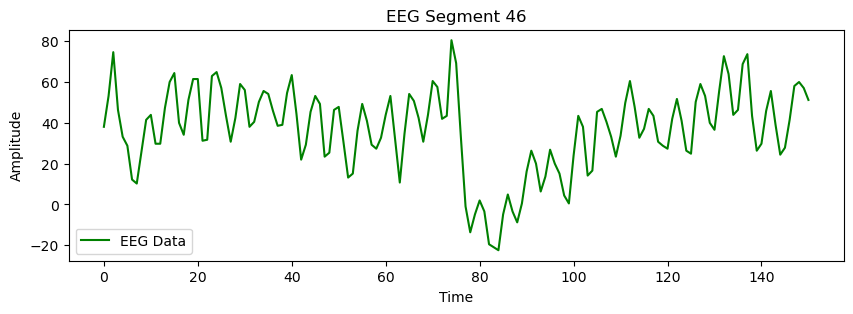

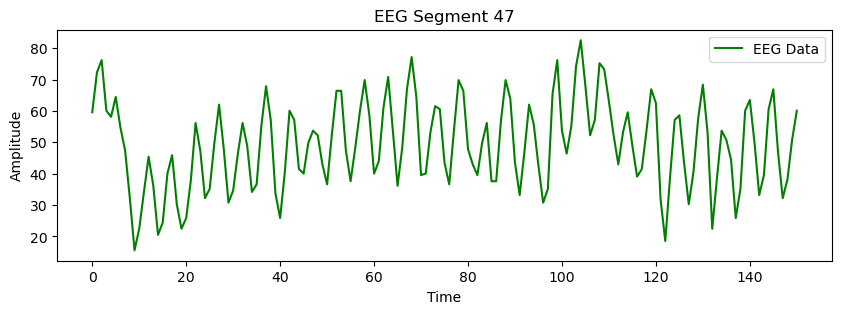

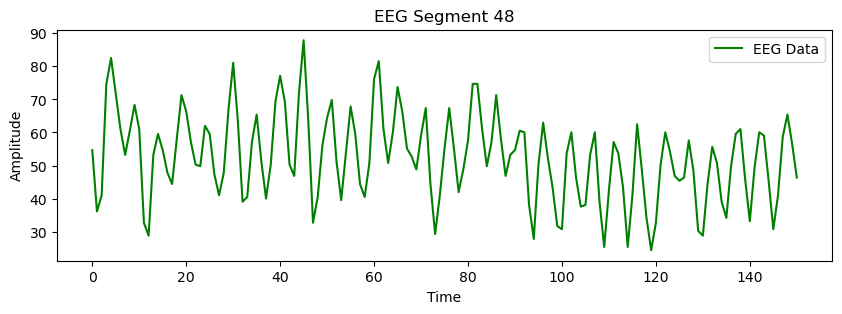

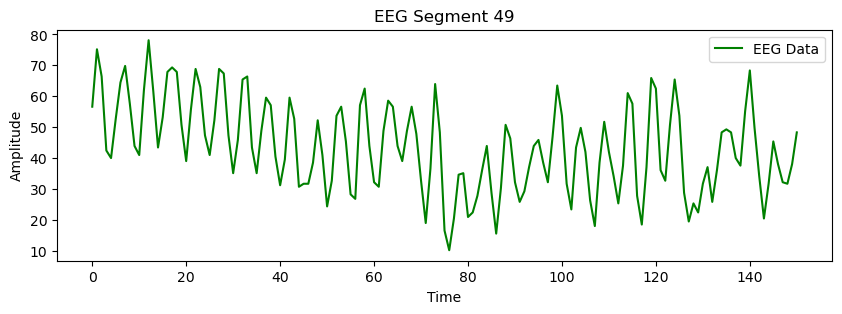

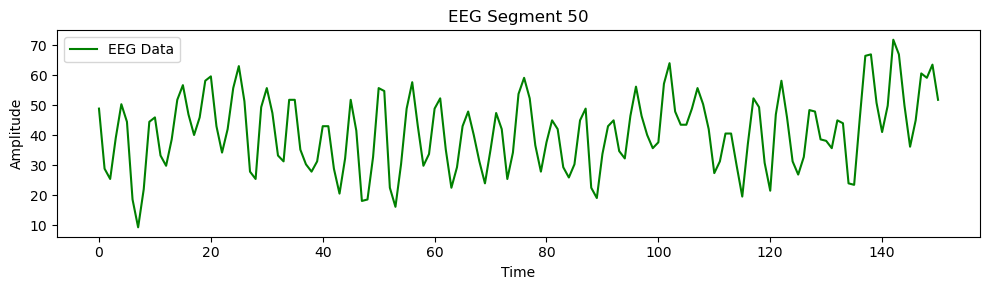

In [343]:
for i in range(0, 50):
    segment_data = conca1_segments[i][2]
    
    plt.figure(figsize=(10, 3))

    time = np.arange(len(segment_data))
    plt.plot(time, segment_data, label='EEG Data', color='g')
    
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'EEG Segment {i+1}')
    plt.legend()
    plt.grid(False)

plt.tight_layout()
plt.show()


In [344]:
features1.head()

fft_1     fft_2     fft_3     fft_4     fft_5     fft_6     fft_7  \
0  0.445946  0.486486  0.479730  0.472973  0.439189  0.500000  0.493243   
1  0.439189  0.452703  0.493243  0.466216  0.500000  0.486486  0.479730   
2  0.175676  0.432432  0.385135  0.466216  0.405405  0.412162  0.493243   
3  0.418919  0.337838  0.459459  0.486486  0.432432  0.500000  0.479730   
4  0.459459  0.493243  0.466216  0.391892  0.500000  0.486486  0.412162   

      fft_8     fft_9    fft_10  ...  fft_seventh_27  fft_seventh_28  \
0  0.378378  0.466216  0.459459  ...        0.285582        0.452865   
1  0.459459  0.412162  0.405405  ...        0.466728        0.463031   
2  0.500000  0.472973  0.317568  ...        0.475046        0.384473   
3  0.493243  0.412162  0.358108  ...        0.402957        0.402033   
4  0.439189  0.479730  0.304054  ...        0.362292        0.494455   

   fft_seventh_29  fft_seventh_30       mean        std     min      max  \
0        0.426987        0.453789  67.967980  19.580493  20.020  113.770   
1        0.453789        0.486137  70.597079  20.685808  24.902  108.398   
2        0.465804        0.476895  50.454649  15.022845  16.602  106.445   
3        0.472274        0.489834  27.130298  15.496054 -16.602   63.965   
4        0.135860        0.461183  30.118212  14.509710  -2.930   68.848   

   electrode        target  
0        TP9  Concentrated  
1        TP9  Concentrated  
2        TP9  Concentrated  
3        TP9  Concentrated  
4        TP9  Concentrated  

[5 rows x 126 columns]

In [345]:
conca2_extractor = EEGSegmentExtractor(conca2, "conca2")
conca2_segments = conca2_extractor.segment_signals()
features2 = conca2_extractor.extract_features()

In [346]:
features2.head()

fft_1     fft_2     fft_3     fft_4     fft_5     fft_6     fft_7  \
0  0.500000  0.469231  0.084615  0.207692  0.492308  0.438462  0.484615   
1  0.484615  0.446154  0.461538  0.169231  0.438462  0.476923  0.315385   
2  0.438462  0.492308  0.023077  0.469231  0.476923  0.484615  0.500000   
3  0.484615  0.469231  0.492308  0.369231  0.500000  0.276923  0.353846   
4  0.476923  0.253846  0.500000  0.423077  0.338462  0.407692  0.430769   

      fft_8     fft_9    fft_10  ...  fft_seventh_27  fft_seventh_28  \
0  0.476923  0.423077  0.415385  ...        0.493711        0.447589   
1  0.500000  0.492308  0.453846  ...        0.488470        0.253669   
2  0.453846  0.238462  0.461538  ...        0.423480        0.486373   
3  0.446154  0.453846  0.300000  ...        0.479036        0.376310   
4  0.323077  0.292308  0.300000  ...        0.361635        0.451782   

   fft_seventh_29  fft_seventh_30      mean        std     min     max  \
0        0.132075        0.441300 -6.009925  21.328888 -59.082  40.527   
1        0.490566        0.407757 -8.719293  11.716421 -39.062  18.555   
2        0.440252        0.449686 -7.122338  18.926045 -46.875  33.691   
3        0.485325        0.283019  0.286316  15.071073 -31.250  34.180   
4        0.482180        0.496855 -1.508917  19.961308 -48.828  34.180   

   electrode        target  
0        TP9  Concentrated  
1        TP9  Concentrated  
2        TP9  Concentrated  
3        TP9  Concentrated  
4        TP9  Concentrated  

[5 rows x 126 columns]

In [347]:
neuta1_extractor = EEGSegmentExtractor(neuta1, "neuta1")
neuta1_segments = neuta1_extractor.segment_signals()
features3 = neuta1_extractor.extract_features()

In [348]:
features3.head()

fft_1     fft_2     fft_3     fft_4     fft_5     fft_6     fft_7  \
0  0.493333  0.500000  0.440000  0.480000  0.380000  0.406667  0.486667   
1  0.446667  0.480000  0.493333  0.466667  0.460000  0.486667  0.500000   
2  0.386667  0.433333  0.500000  0.493333  0.486667  0.480000  0.426667   
3  0.306667  0.480000  0.466667  0.326667  0.500000  0.426667  0.473333   
4  0.346667  0.340000  0.386667  0.373333  0.440000  0.280000  0.333333   

      fft_8     fft_9    fft_10  ...  fft_seventh_27  fft_seventh_28  \
0  0.453333  0.433333  0.460000  ...        0.492620        0.486162   
1  0.473333  0.400000  0.406667  ...        0.487085        0.467712   
2  0.453333  0.446667  0.473333  ...        0.491697        0.488007   
3  0.093333  0.440000  0.493333  ...        0.396679        0.268450   
4  0.493333  0.446667  0.500000  ...        0.434502        0.471402   

   fft_seventh_29  fft_seventh_30       mean        std     min      max  \
0        0.243542        0.434502   2.505645  30.698259 -70.312   52.734   
1        0.452952        0.463100  49.451309  26.675386   2.441  120.117   
2        0.436347        0.032288  23.922612  12.133331  -8.301   58.105   
3        0.475092        0.452030  18.124217  10.594638  -8.301   40.527   
4        0.495387        0.453875  18.403750  10.477665  -5.859   46.387   

   electrode   target  
0        TP9  Neutral  
1        TP9  Neutral  
2        TP9  Neutral  
3        TP9  Neutral  
4        TP9  Neutral  

[5 rows x 126 columns]

In [349]:
neuta2_extractor = EEGSegmentExtractor(neuta2, "neuta2")
neuta2_segments = neuta2_extractor.segment_signals()
features4 = neuta1_extractor.extract_features()

In [350]:
features4.head()

fft_1     fft_2     fft_3     fft_4     fft_5     fft_6     fft_7  \
0  0.493333  0.500000  0.440000  0.480000  0.380000  0.406667  0.486667   
1  0.446667  0.480000  0.493333  0.466667  0.460000  0.486667  0.500000   
2  0.386667  0.433333  0.500000  0.493333  0.486667  0.480000  0.426667   
3  0.306667  0.480000  0.466667  0.326667  0.500000  0.426667  0.473333   
4  0.346667  0.340000  0.386667  0.373333  0.440000  0.280000  0.333333   

      fft_8     fft_9    fft_10  ...  fft_seventh_27  fft_seventh_28  \
0  0.453333  0.433333  0.460000  ...        0.492620        0.486162   
1  0.473333  0.400000  0.406667  ...        0.487085        0.467712   
2  0.453333  0.446667  0.473333  ...        0.491697        0.488007   
3  0.093333  0.440000  0.493333  ...        0.396679        0.268450   
4  0.493333  0.446667  0.500000  ...        0.434502        0.471402   

   fft_seventh_29  fft_seventh_30       mean        std     min      max  \
0        0.243542        0.434502   2.505645  30.698259 -70.312   52.734   
1        0.452952        0.463100  49.451309  26.675386   2.441  120.117   
2        0.436347        0.032288  23.922612  12.133331  -8.301   58.105   
3        0.475092        0.452030  18.124217  10.594638  -8.301   40.527   
4        0.495387        0.453875  18.403750  10.477665  -5.859   46.387   

   electrode   target  
0        TP9  Neutral  
1        TP9  Neutral  
2        TP9  Neutral  
3        TP9  Neutral  
4        TP9  Neutral  

[5 rows x 126 columns]

In [351]:
relaxa1_extractor = EEGSegmentExtractor(relaxa1, "relaxa1")
relaxa1_segments = relaxa1_extractor.segment_signals()
features5 = relaxa1_extractor.extract_features()

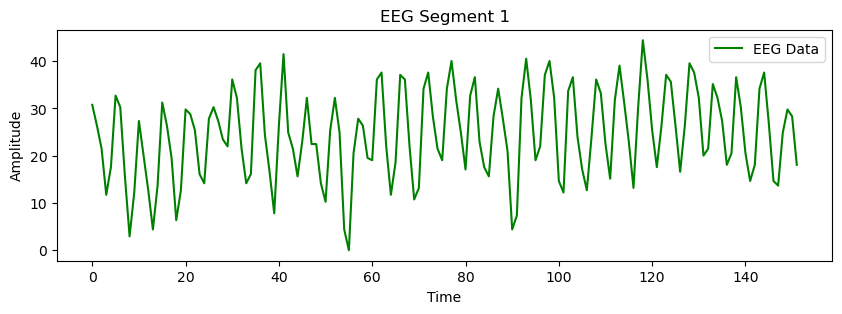

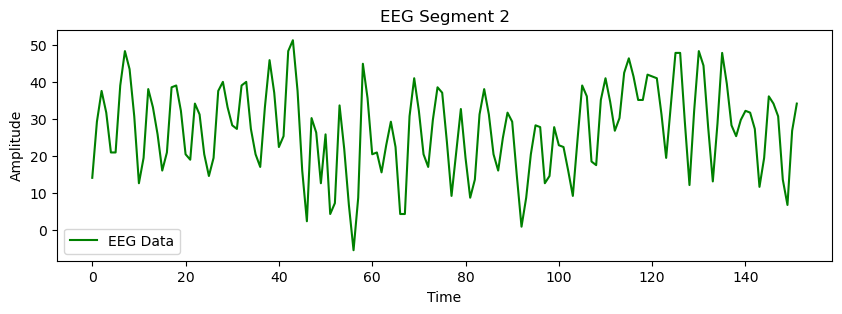

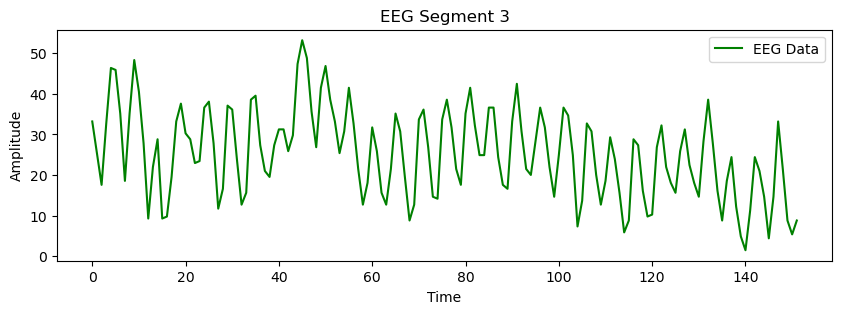

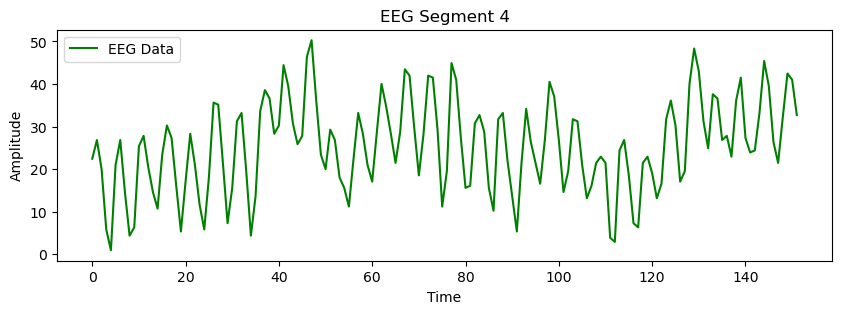

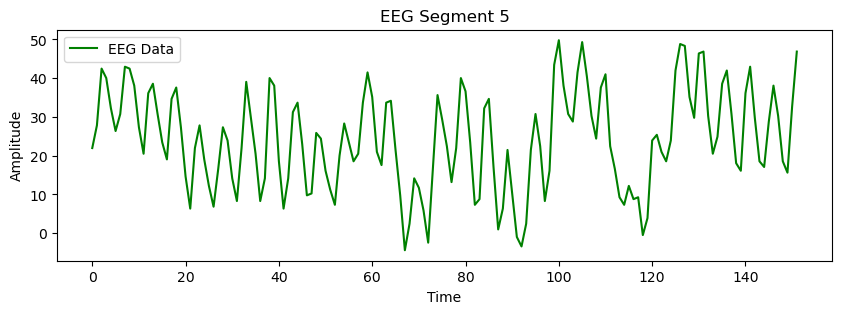

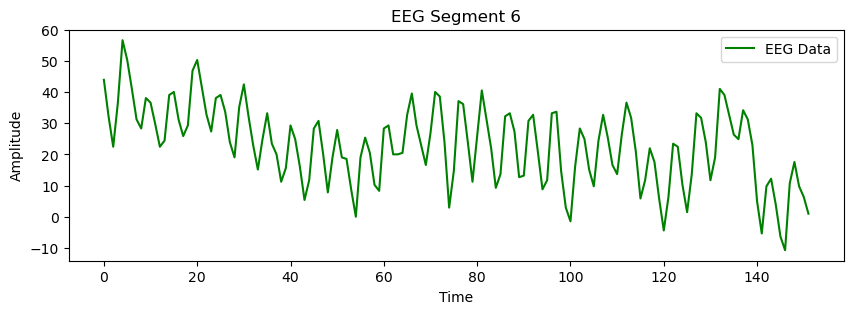

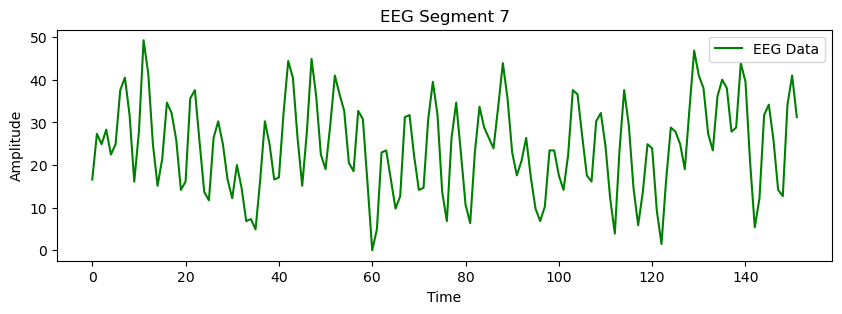

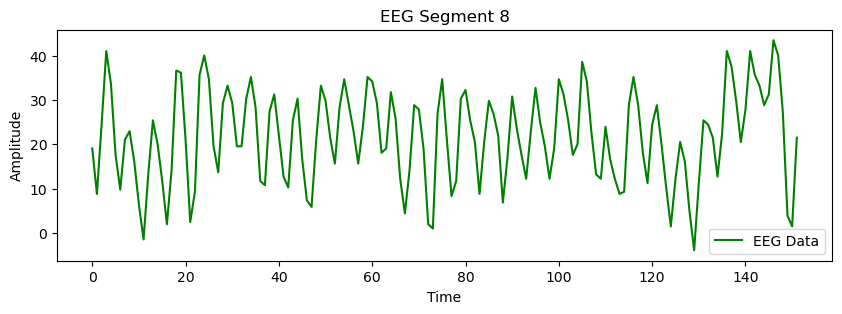

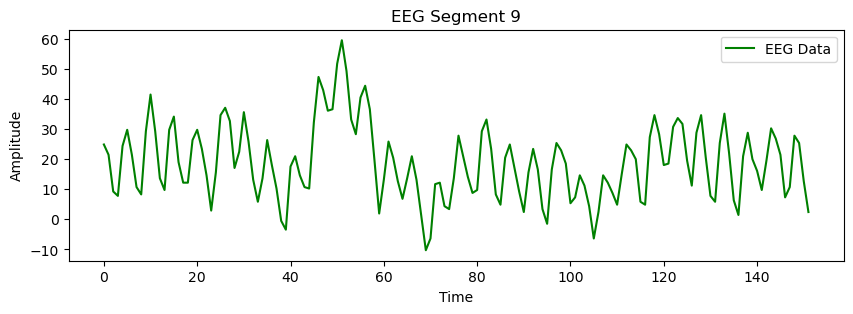

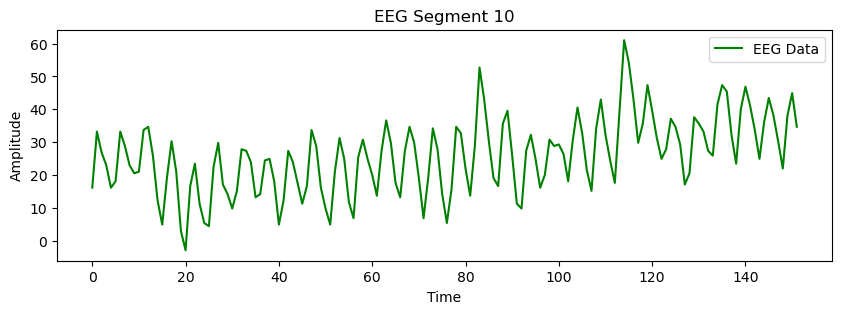

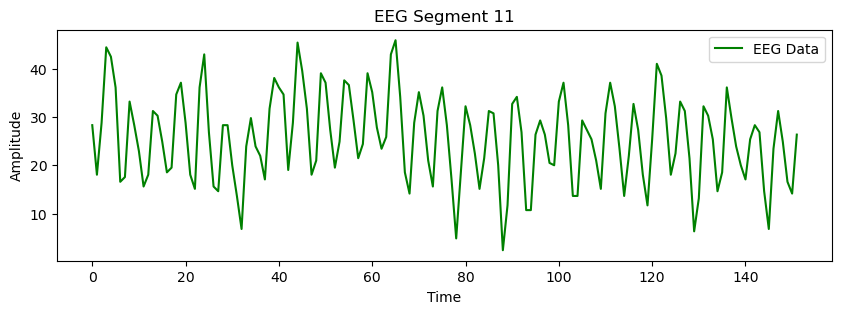

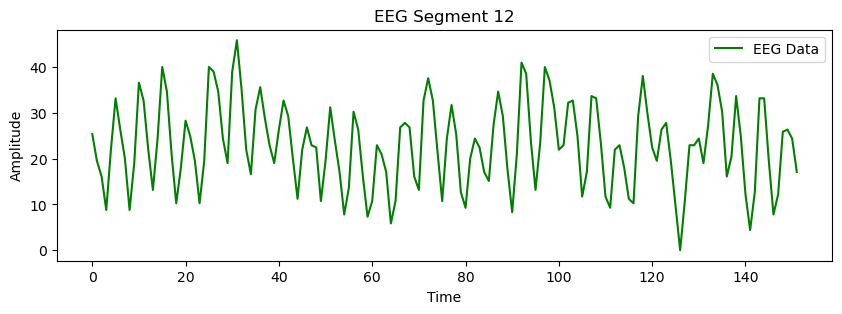

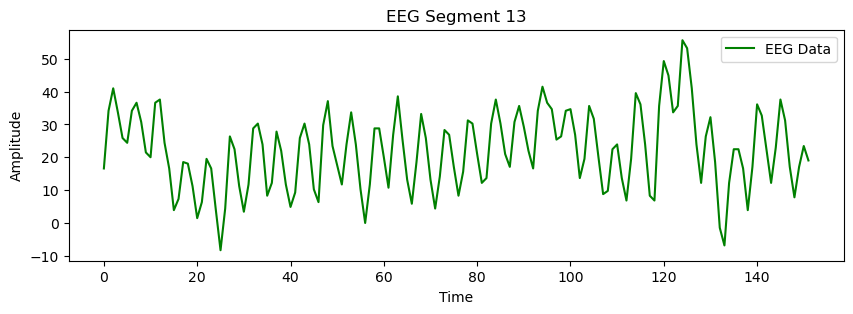

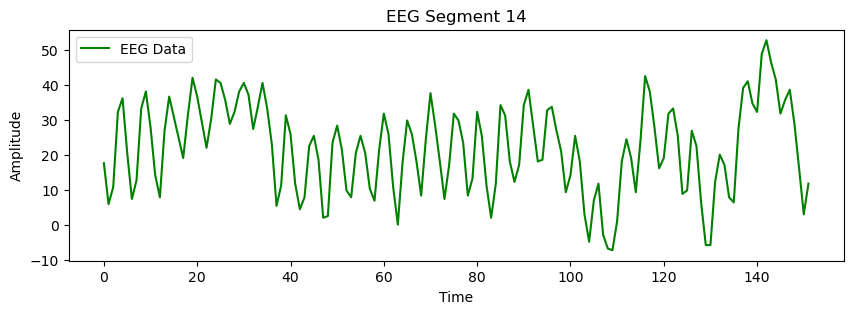

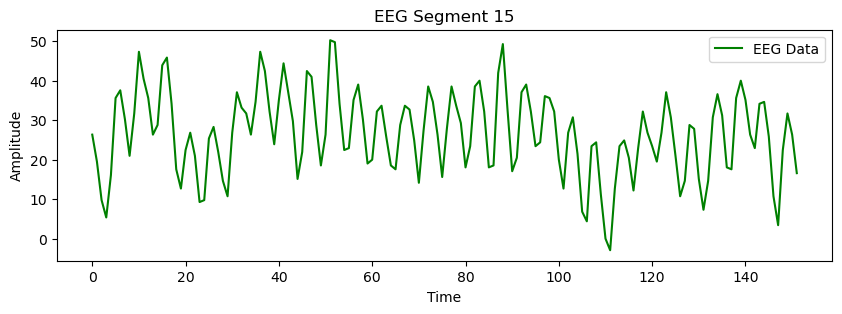

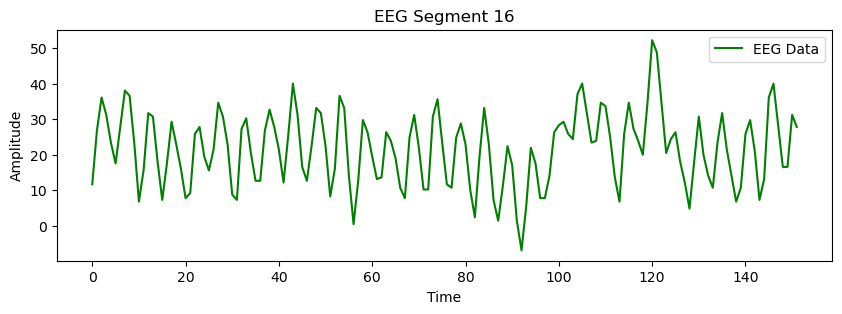

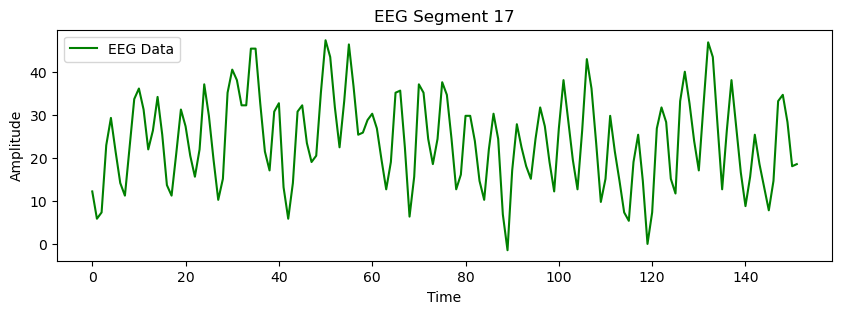

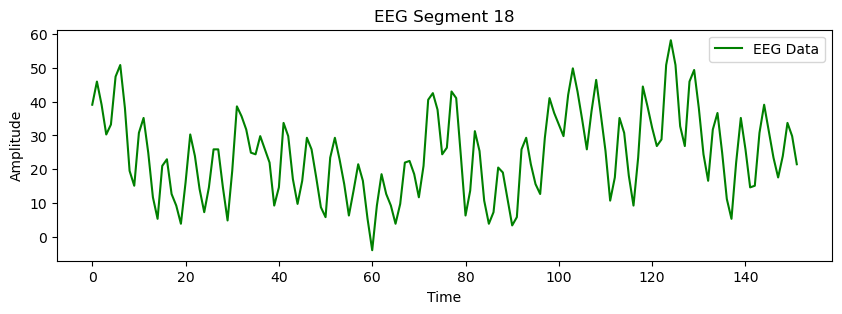

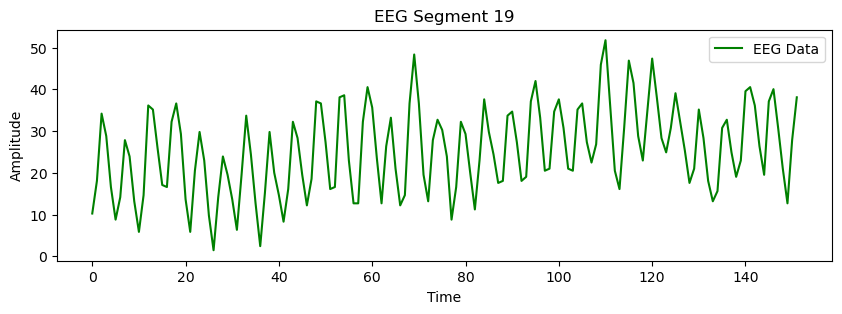

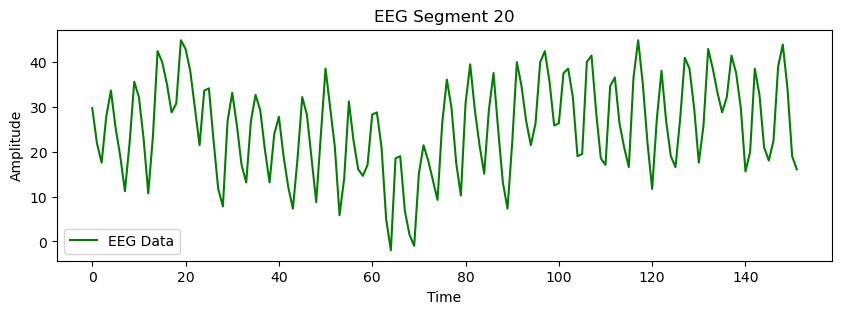

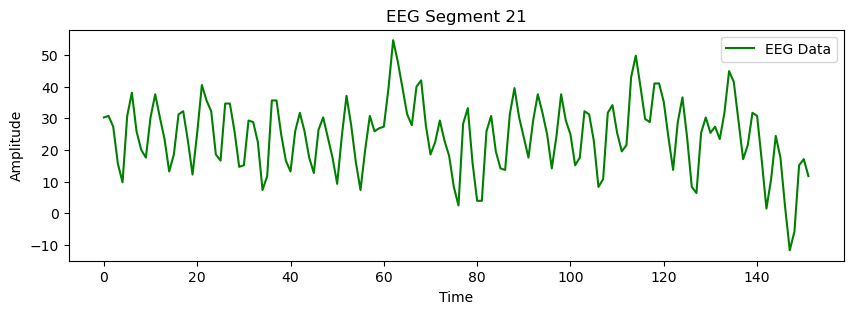

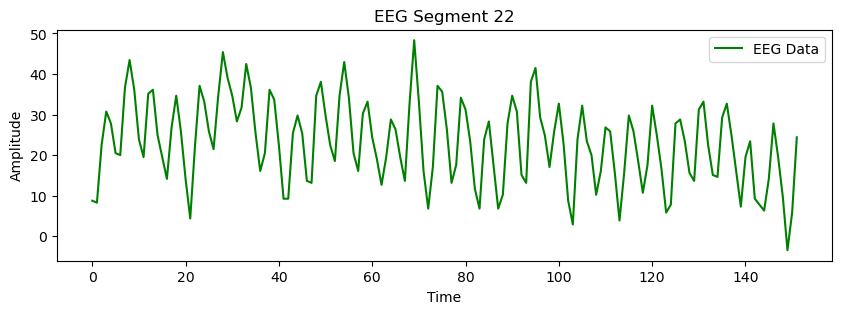

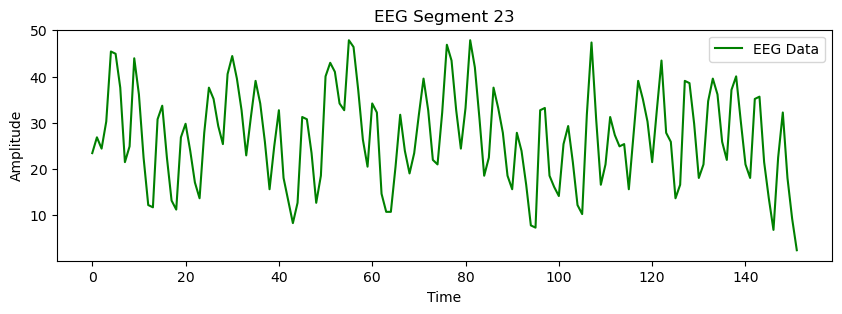

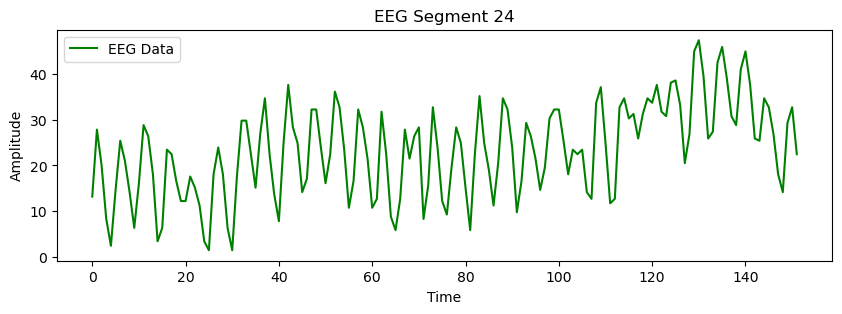

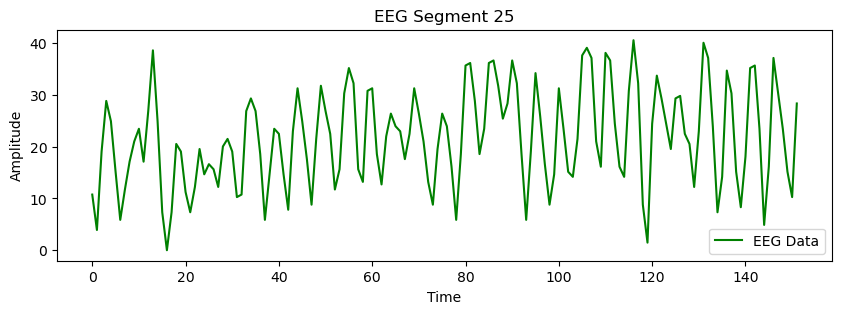

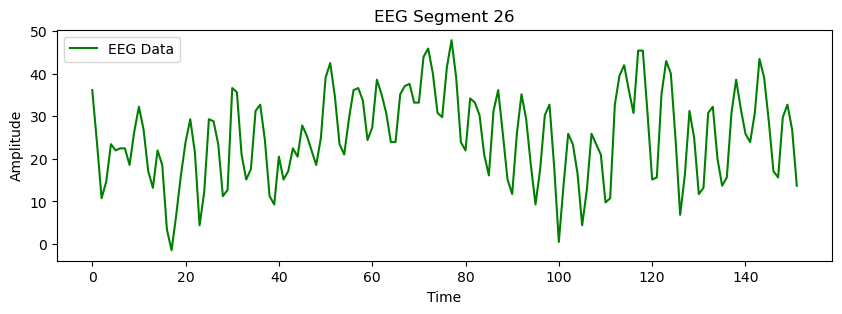

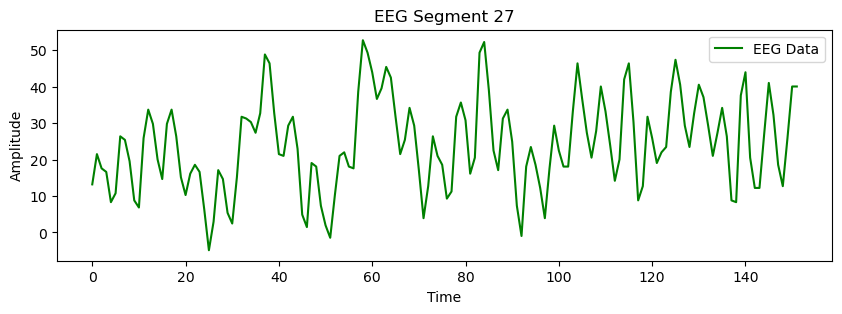

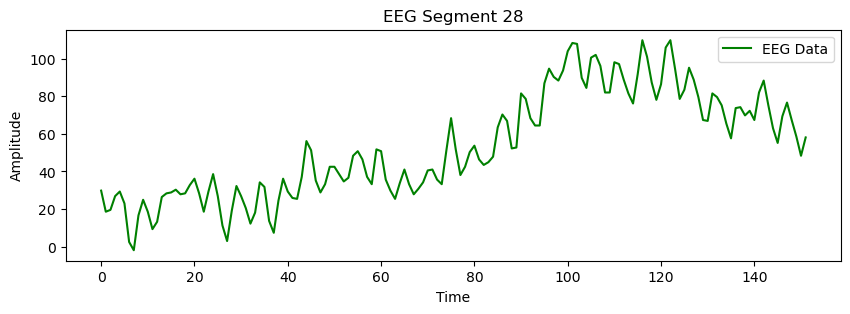

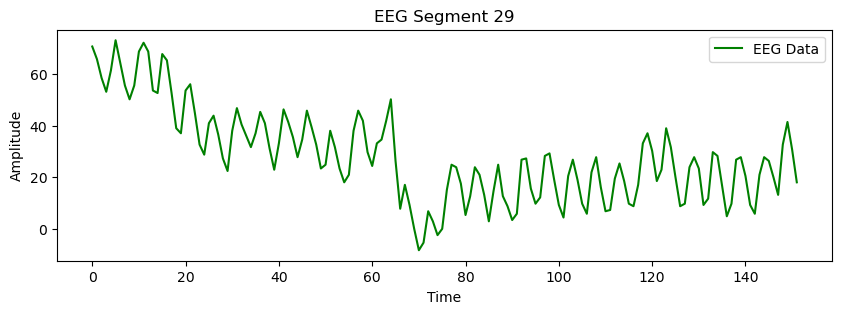

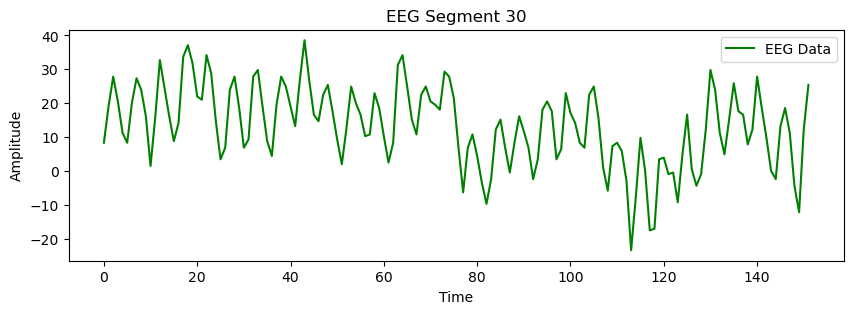

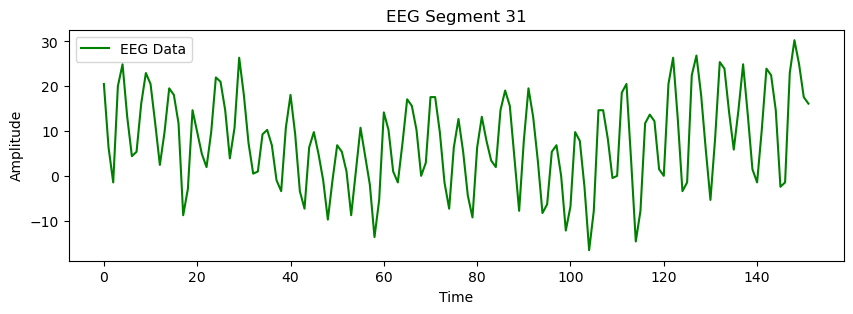

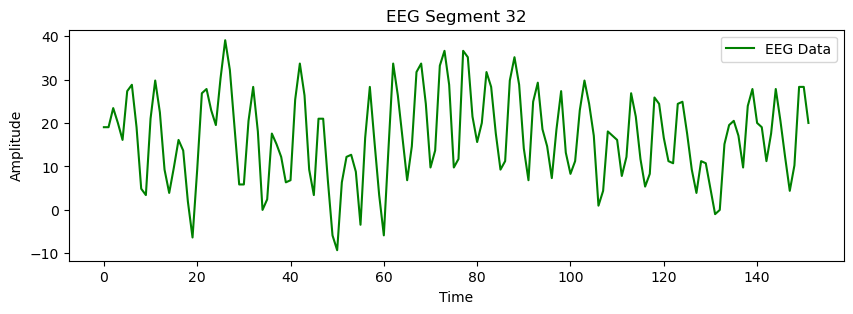

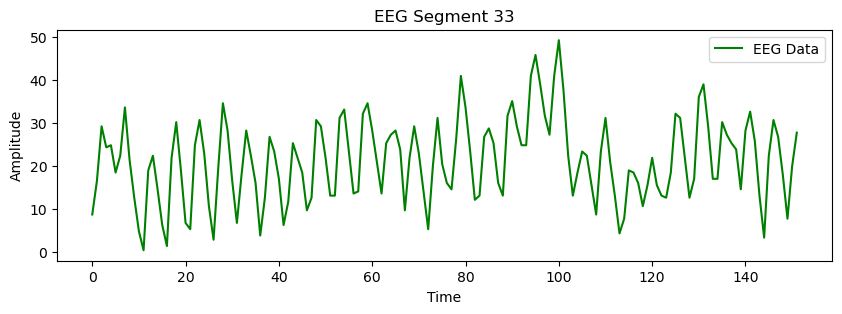

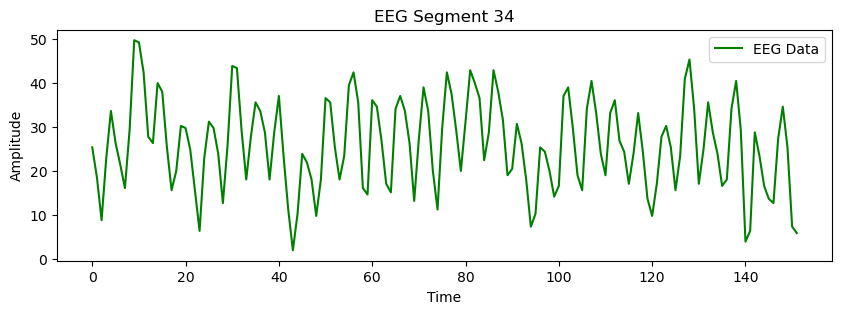

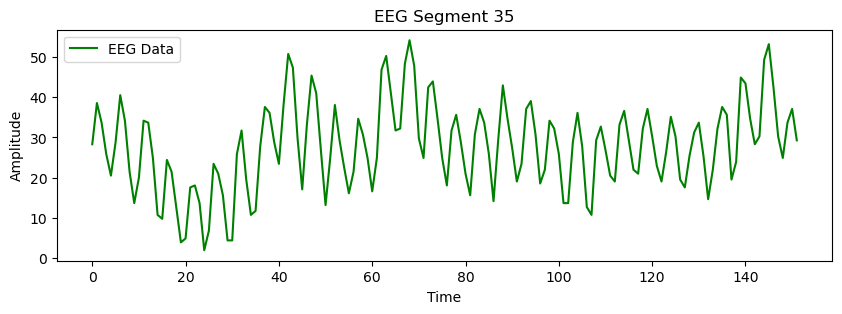

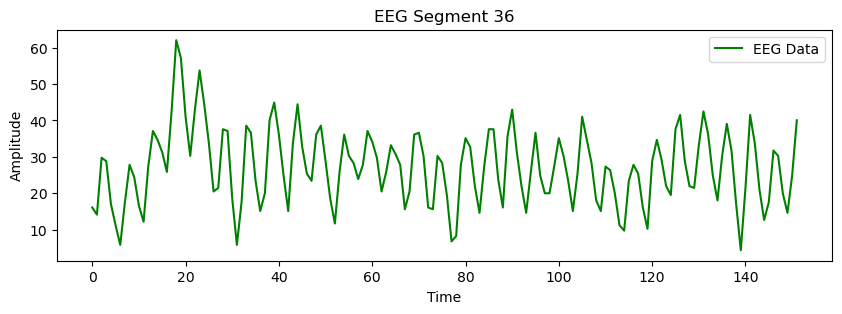

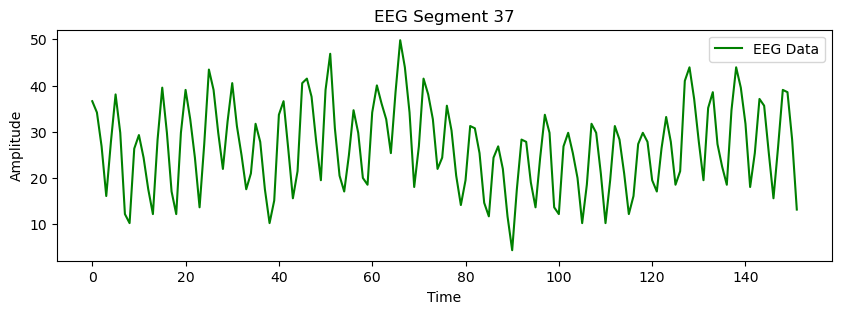

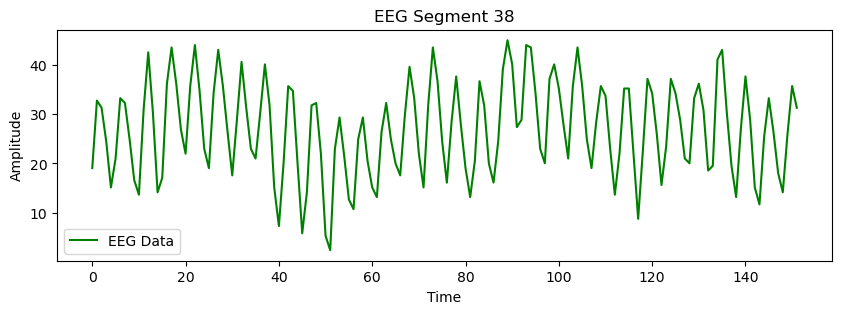

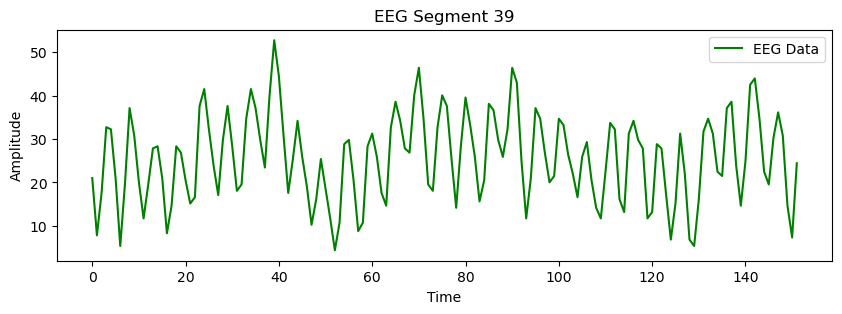

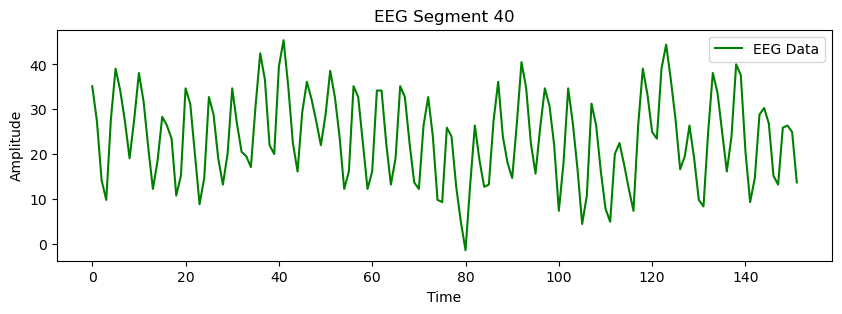

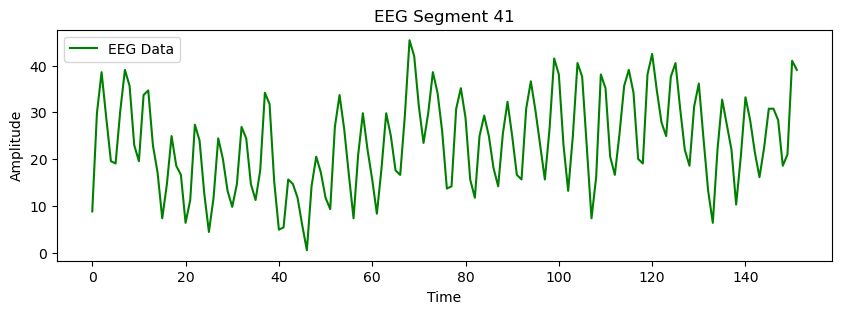

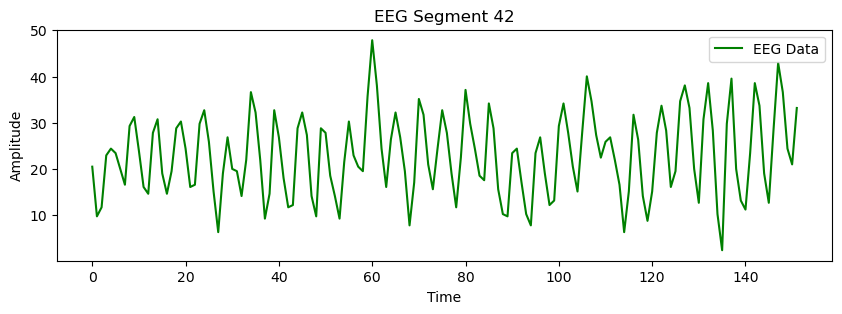

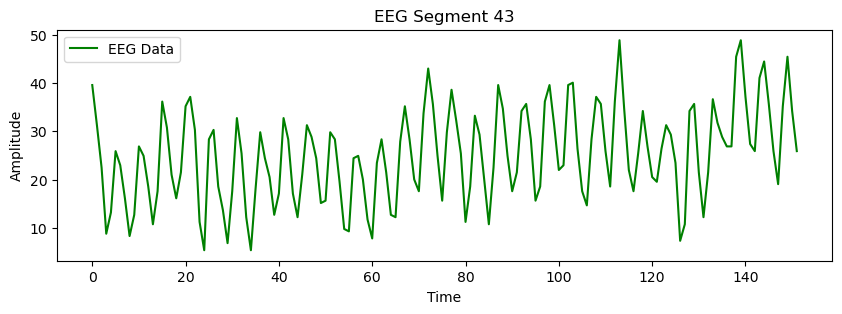

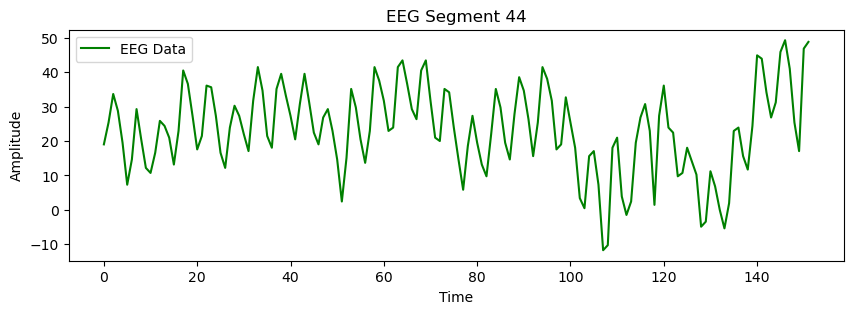

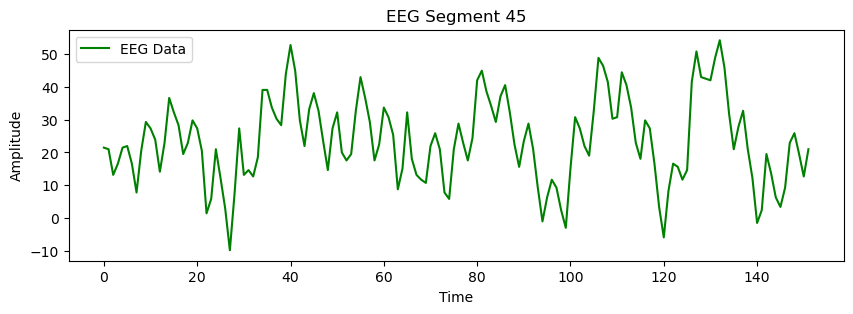

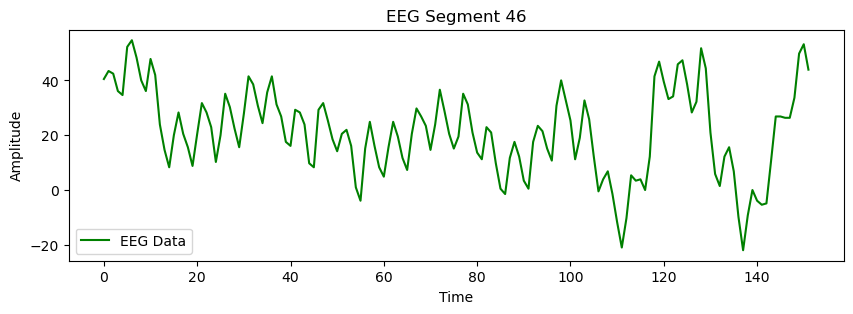

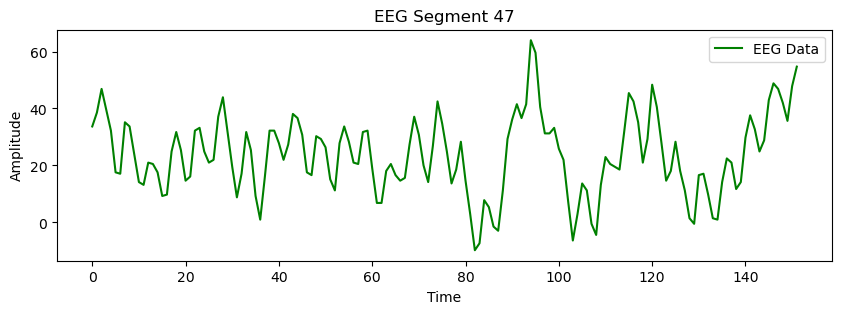

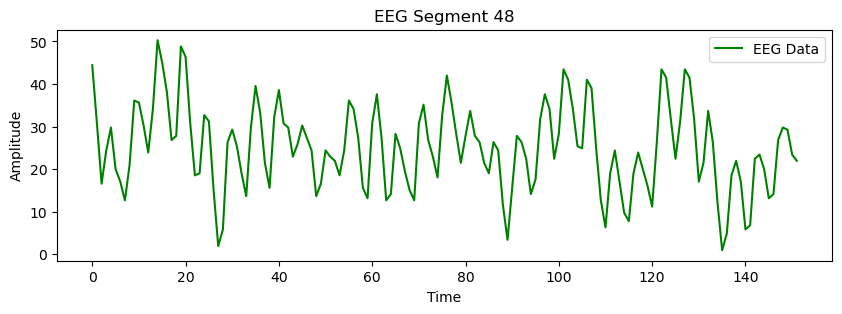

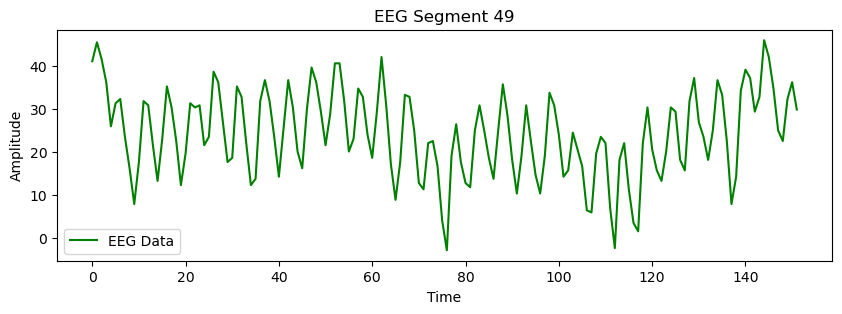

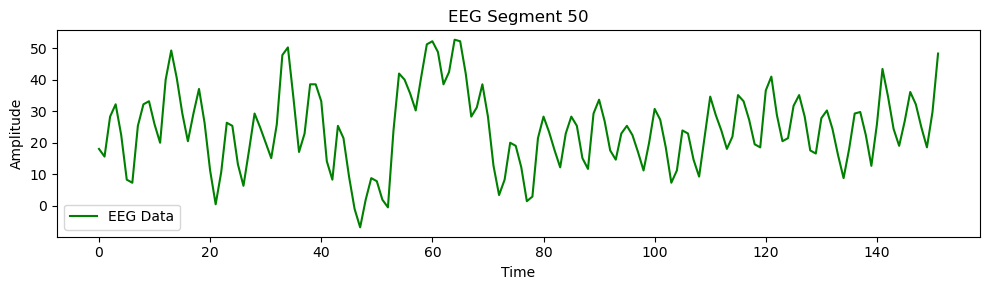

In [352]:
for i in range(0, 50):
    segment_data = relaxa1_segments[i][2]
    
    plt.figure(figsize=(10, 3))

    time = np.arange(len(segment_data))
    plt.plot(time, segment_data, label='EEG Data', color='g')
    
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'EEG Segment {i+1}')
    plt.legend()
    plt.grid(False)

plt.tight_layout()
plt.show()

In [353]:
features5.head()

fft_1     fft_2     fft_3     fft_4     fft_5     fft_6     fft_7  \
0  0.453333  0.046667  0.446667  0.260000  0.366667  0.460000  0.480000   
1  0.426667  0.433333  0.440000  0.493333  0.500000  0.486667  0.466667   
2  0.486667  0.466667  0.460000  0.406667  0.480000  0.420000  0.453333   
3  0.486667  0.500000  0.446667  0.473333  0.286667  0.466667  0.480000   
4  0.406667  0.493333  0.486667  0.460000  0.500000  0.466667  0.433333   

      fft_8     fft_9    fft_10  ...  fft_seventh_27  fft_seventh_28  \
0  0.493333  0.106667  0.440000  ...        0.464945        0.487085   
1  0.413333  0.473333  0.480000  ...        0.316421        0.466790   
2  0.500000  0.493333  0.426667  ...        0.492620        0.328413   
3  0.493333  0.460000  0.453333  ...        0.490775        0.497232   
4  0.480000  0.360000  0.426667  ...        0.274908        0.482472   

   fft_seventh_29  fft_seventh_30       mean        std    min     max  \
0        0.484317        0.491697  24.565053   9.479173  0.000  44.434   
1        0.465867        0.321956  27.134947  11.678102 -5.371  51.270   
2        0.494465        0.450185  25.313480  10.860625  1.465  53.223   
3        0.440959        0.485240  25.348829  10.842114  0.977  50.293   
4        0.493542        0.454797  24.192441  12.824847 -4.395  49.805   

   electrode   target  
0        TP9  Relaxed  
1        TP9  Relaxed  
2        TP9  Relaxed  
3        TP9  Relaxed  
4        TP9  Relaxed  

[5 rows x 126 columns]

In [354]:
relaxa2_extractor = EEGSegmentExtractor(relaxa2, "relaxa2")
relaxa2_segments = relaxa2_extractor.segment_signals()
features6 = relaxa2_extractor.extract_features()

In [355]:
features6.head()

fft_1     fft_2     fft_3     fft_4     fft_5     fft_6     fft_7  \
0  0.446667  0.453333  0.466667  0.473333  0.460000  0.433333  0.426667   
1  0.473333  0.480000  0.486667  0.453333  0.060000  0.500000  0.493333   
2  0.333333  0.366667  0.300000  0.486667  0.306667  0.260000  0.140000   
3  0.100000  0.460000  0.486667  0.433333  0.500000  0.446667  0.480000   
4  0.466667  0.473333  0.480000  0.500000  0.453333  0.493333  0.353333   

      fft_8     fft_9    fft_10  ...  fft_seventh_27  fft_seventh_28  \
0  0.500000  0.480000  0.486667  ...        0.494465        0.476015   
1  0.353333  0.266667  0.466667  ...        0.493542        0.492620   
2  0.353333  0.460000  0.500000  ...        0.468635        0.467712   
3  0.440000  0.493333  0.466667  ...        0.498155        0.497232   
4  0.486667  0.440000  0.446667  ...        0.476015        0.476937   

   fft_seventh_29  fft_seventh_30       mean        std     min     max  \
0        0.355166        0.477860  24.112099  14.629812  -4.883  55.176   
1        0.476015        0.484317  25.499842  15.176943  -5.859  58.594   
2        0.367159        0.484317  26.739829  14.449733  -0.977  61.035   
3        0.455720        0.473247  22.621533  15.773210 -13.184  55.664   
4        0.495387        0.452952  21.619296  15.487163 -20.508  53.711   

   electrode   target  
0        TP9  Relaxed  
1        TP9  Relaxed  
2        TP9  Relaxed  
3        TP9  Relaxed  
4        TP9  Relaxed  

[5 rows x 126 columns]

In [356]:
# For relaxb - Version 1
relaxb1_extractor = EEGSegmentExtractor(relaxb1, "relaxb1")
relaxb1_segments = relaxb1_extractor.segment_signals()
features7 = relaxb1_extractor.extract_features()

In [357]:
# For relaxb - Version 2
relaxb2_extractor = EEGSegmentExtractor(relaxb2, "relaxb2")
relaxb2_segments = relaxb2_extractor.segment_signals()
features8 = relaxb2_extractor.extract_features()

In [358]:
# For relaxc - Version 1
relaxc1_extractor = EEGSegmentExtractor(relaxc1, "relaxc1")
relaxc1_segments = relaxc1_extractor.segment_signals()
features9 = relaxc1_extractor.extract_features()

In [359]:
# For relaxc - Version 2
relaxc2_extractor = EEGSegmentExtractor(relaxc2, "relaxc2")
relaxc2_segments = relaxc2_extractor.segment_signals()
features10 = relaxc2_extractor.extract_features()

In [360]:
# For relaxd - Version 1
relaxd1_extractor = EEGSegmentExtractor(relaxd1, "relaxd1")
relaxd1_segments = relaxd1_extractor.segment_signals()
features11 = relaxd1_extractor.extract_features()

In [361]:
# # For relaxd - Version 2
# relaxd2_extractor = EEGSegmentExtractor(relaxd2, "relaxd2")
# relaxd2_segments = relaxd2_extractor.segment_signals()
# features12 = relaxd2_extractor.extract_features()

In [362]:
# For concb - Version 1
concb1_extractor = EEGSegmentExtractor(concb1, "concb1")
concb1_segments = concb1_extractor.segment_signals()
features13 = concb1_extractor.extract_features()

In [363]:
# For concb - Version 2
concb2_extractor = EEGSegmentExtractor(concb2, "concb2")
concb2_segments = concb2_extractor.segment_signals()
features14 = concb2_extractor.extract_features()

In [364]:
# For concc - Version 1
concc1_extractor = EEGSegmentExtractor(concc1, "concc1")
concc1_segments = concc1_extractor.segment_signals()
features15 = concc1_extractor.extract_features()

In [365]:
# For concc - Version 2
concc2_extractor = EEGSegmentExtractor(concc2, "concc2")
concc2_segments = concc2_extractor.segment_signals()
features16 = concc2_extractor.extract_features()

In [366]:
# For concd - Version 1
concd1_extractor = EEGSegmentExtractor(concd1, "concd1")
concd1_segments = concd1_extractor.segment_signals()
features17 = concd1_extractor.extract_features()

In [367]:
# # For concd - Version 2
# concd2_extractor = EEGSegmentExtractor(concd2, "concd2")
# concd2_segments = concd2_extractor.segment_signals()
# features18 = concd2_extractor.extract_features()

In [368]:
# For neutb - Version 1
neutb1_extractor = EEGSegmentExtractor(neutb1, "neutb1")
neutb1_segments = neutb1_extractor.segment_signals()
features19 = neutb1_extractor.extract_features()

In [369]:
# For neutb - Version 2
neutb2_extractor = EEGSegmentExtractor(neutb2, "neutb2")
neutb2_segments = neutb2_extractor.segment_signals()
features20 = neutb2_extractor.extract_features()

In [370]:
# For neutc - Version 1
neutc1_extractor = EEGSegmentExtractor(neutc1, "neutc1")
neutc1_segments = neutc1_extractor.segment_signals()
features21 = neutc1_extractor.extract_features()

In [371]:
# # For neutc - Version 2
# neutc2_extractor = EEGSegmentExtractor(neutc2, "neutc2")
# neutc2_segments = neutc2_extractor.segment_signals()
# features22 = neutc2_extractor.extract_features()

In [372]:
# For neut - Version 1
neutd1_extractor = EEGSegmentExtractor(neutd1, "neutd1")
neutd1_segments = neutd1_extractor.segment_signals()
features23 = neutd1_extractor.extract_features()

In [373]:
# For neut - Version 2
neutd2_extractor = EEGSegmentExtractor(neutd2, "neutd2")
neutd2_segments = neutd2_extractor.segment_signals()
features24 = neutd2_extractor.extract_features()

In [374]:
# Create a list of DataFrames
feature_dfs = [features1, features2, features3, features4, features5, features6,
               features7, features8, features9, features10, features11,
               features13, features14, features15, features16, features17,
               features19, features20, features21, features23, features24]

# Concatenate the DataFrames along rows
final_features = pd.concat(feature_dfs, ignore_index=True)

In [375]:
final_features = final_features.dropna(axis = 0)
final_features

fft_1     fft_2     fft_3     fft_4     fft_5     fft_6     fft_7  \
0      0.445946  0.486486  0.479730  0.472973  0.439189  0.500000  0.493243   
1      0.439189  0.452703  0.493243  0.466216  0.500000  0.486486  0.479730   
2      0.175676  0.432432  0.385135  0.466216  0.405405  0.412162  0.493243   
3      0.418919  0.337838  0.459459  0.486486  0.432432  0.500000  0.479730   
4      0.459459  0.493243  0.466216  0.391892  0.500000  0.486486  0.412162   
...         ...       ...       ...       ...       ...       ...       ...   
10065  0.446667  0.453333  0.480000  0.440000  0.433333  0.466667  0.340000   
10066  0.353333  0.340000  0.453333  0.500000  0.473333  0.440000  0.433333   
10067  0.446667  0.293333  0.280000  0.473333  0.366667  0.266667  0.440000   
10068  0.346667  0.500000  0.480000  0.333333  0.493333  0.486667  0.300000   
10069  0.380000  0.493333  0.500000  0.466667  0.433333  0.440000  0.426667   

          fft_8     fft_9    fft_10  ...  fft_seventh_27  fft_seventh_28  \
0      0.378378  0.466216  0.459459  ...        0.285582        0.452865   
1      0.459459  0.412162  0.405405  ...        0.466728        0.463031   
2      0.500000  0.472973  0.317568  ...        0.475046        0.384473   
3      0.493243  0.412162  0.358108  ...        0.402957        0.402033   
4      0.439189  0.479730  0.304054  ...        0.362292        0.494455   
...         ...       ...       ...  ...             ...             ...   
10065  0.320000  0.360000  0.493333  ...        0.490775        0.455720   
10066  0.406667  0.493333  0.466667  ...        0.419742        0.428967   
10067  0.413333  0.460000  0.406667  ...        0.363469        0.493542   
10068  0.466667  0.280000  0.473333  ...        0.428967        0.476015   
10069  0.460000  0.486667  0.246667  ...        0.012915        0.490775   

       fft_seventh_29  fft_seventh_30       mean        std     min      max  \
0            0.426987        0.453789  67.967980  19.580493  20.020  113.770   
1            0.453789        0.486137  70.597079  20.685808  24.902  108.398   
2            0.465804        0.476895  50.454649  15.022845  16.602  106.445   
3            0.472274        0.489834  27.130298  15.496054 -16.602   63.965   
4            0.135860        0.461183  30.118212  14.509710  -2.930   68.848   
...               ...             ...        ...        ...     ...      ...   
10065        0.133764        0.497232  33.755664  16.509955   1.465   75.195   
10066        0.450185        0.464945  26.392895  10.032960   3.906   60.547   
10067        0.383764        0.437269  22.653678   9.476283   1.465   47.363   
10068        0.481550        0.450185  25.532000   9.470557   6.836   47.852   
10069        0.499077        0.467712  22.920289   9.337857  -0.977   45.898   

       electrode        target  
0            TP9  Concentrated  
1            TP9  Concentrated  
2            TP9  Concentrated  
3            TP9  Concentrated  
4            TP9  Concentrated  
...          ...           ...  
10065        TP9       Neutral  
10066        TP9       Neutral  
10067        TP9       Neutral  
10068        TP9       Neutral  
10069        TP9       Neutral  

[1470 rows x 126 columns]

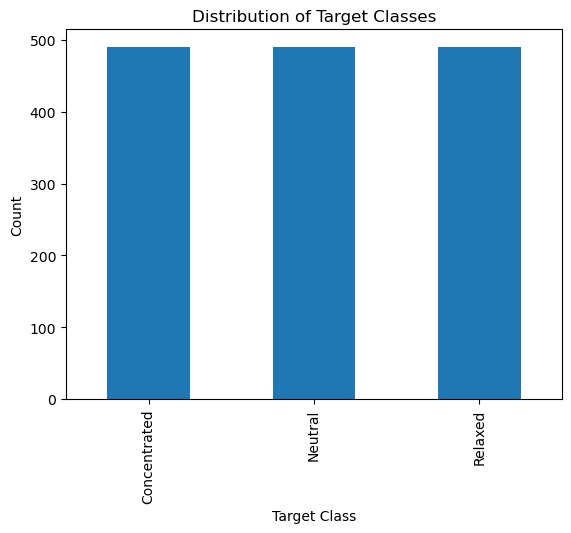

In [376]:
final_features['target'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Classes')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.show()

# Statistical Analysis

In [377]:
target_name_1 = features1['target'].unique()
target_name_2 = features7['target'].unique()
target_name_3 = features21['target'].unique()
target_names = list(set(target_name_1) | set(target_name_2) | set(target_name_3))


In [378]:
le_final = LabelEncoder()
final_features['target'] = le_final.fit_transform(final_features['target'])

In [379]:
yf = final_features['target']
Xf = final_features.drop(['target', 'electrode'], axis = 1)

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(Xf, yf, train_size=0.7, random_state=48)


### K-NN Classifier

In [380]:
knn_classifier_final = KNeighborsClassifier(n_neighbors = 3)

knn_pipeline_final = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', knn_classifier_final)
])

knn_pipeline_final.fit(X_train_f, y_train_f)
y_pred_final = knn_pipeline_final.predict(X_test_f)


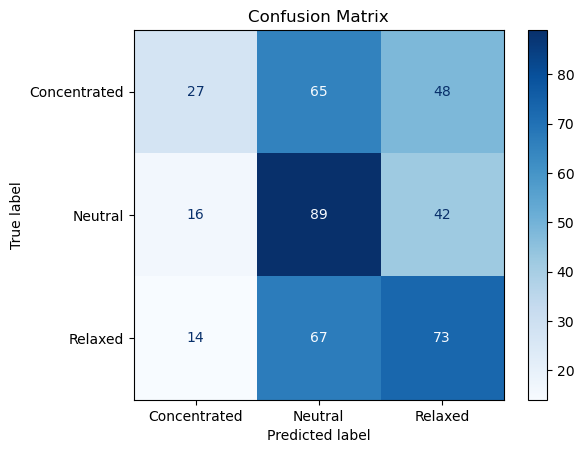

In [381]:
cm = confusion_matrix(y_test_f, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = target_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [382]:
accuracy = accuracy_score(y_test_f, y_pred_final)

# Calculate precision and recall w/ weighted for multiclass labels
precision = precision_score(y_test_f, y_pred_final, average='weighted')
recall = recall_score(y_test_f, y_pred_final, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


Accuracy: 0.43
Precision: 0.44
Recall: 0.43


### Principal Component Analysis

In [383]:
pca_final = PCA(10).fit(final_features.drop(['target', 'electrode'], axis = 1))
explained_variance_final = pca.explained_variance_ratio_


In [384]:
X_train_pca_final = pca.fit_transform(X_train_f)
X_test_pca_final = pca.transform(X_test_f)


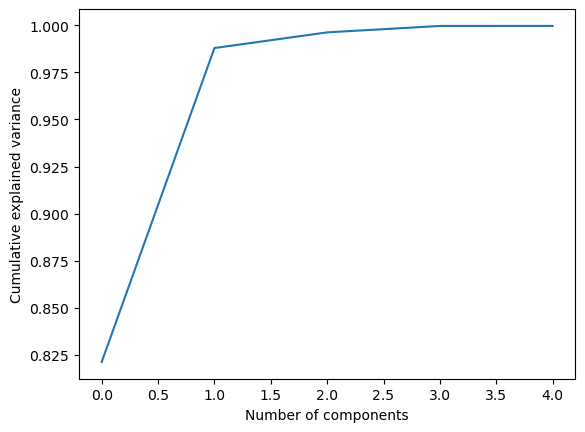

In [385]:
plt.plot(np.cumsum(explained_variance_final))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

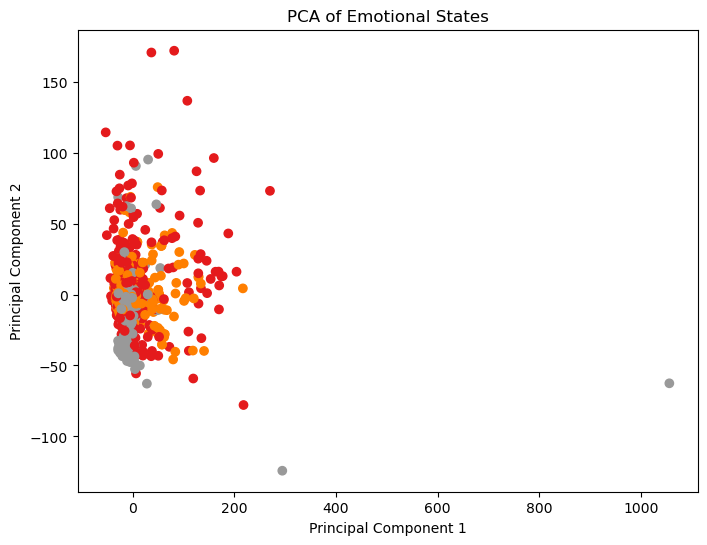

In [389]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca_final[:, 0], X_train_pca_final[:, 1], c=y_train_f, cmap=plt.cm.Set1)
plt.title("PCA of Emotional States")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### XGBoost Classifier w/ PCA

In [390]:
model3 = XGBClassifier(objective='multi:softmax', num_class = 3, eval_metric='logloss')

# Train the classifier on the training data
model3.fit(X_train_pca_final, y_train_f)

# Make predictions on the testing data
y_pred_pca_f = model3.predict(X_test_pca_final)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test_f, y_pred_pca_f)
print(f'Accuracy: {accuracy}', '\n')

# You can also access feature importances if needed
feature_importances = model3.feature_importances_
print('Feature Importances:')
for i, importance in enumerate(feature_importances):
    print(f'Feature {i+1}: {importance}')
    

Accuracy: 0.7074829931972789 

Feature Importances:
Feature 1: 0.2234071046113968
Feature 2: 0.22919301688671112
Feature 3: 0.18651622533798218
Feature 4: 0.17393338680267334
Feature 5: 0.18695031106472015


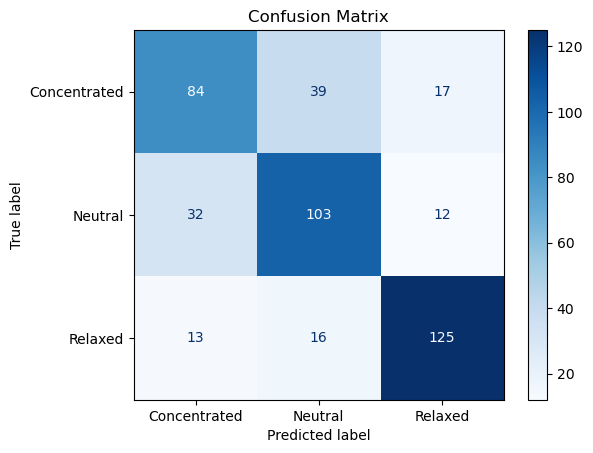

In [391]:
cm = confusion_matrix(y_test_f, y_pred_pca_f)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = target_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

### XGBoost Grid Search

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]}

xgb2 = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='logloss')

grid_search = GridSearchCV(xgb2, param_grid, cv=5, scoring='neg_log_loss')
grid_search.fit(X_train_pca_final, y_train_f)


In [ ]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

In [ ]:
best_xgb = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='logloss', **best_params)
best_xgb.fit(X_train_f, y_train_f)

### Basic Neural Network

In [ ]:
y_train_encoded = to_categorical(y_train_f, 3)
y_test_encoded = to_categorical(y_test_f, 3)

In [ ]:
model4 = keras.Sequential([
    keras.layers.Input(shape=(94,)),
    keras.layers.Dense(64, activation='relu'), 
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model4.fit(X_train_f, y_train_encoded, epochs = 1000, batch_size = 32)

In [ ]:
test_loss, test_accuracy = model4.evaluate(X_test_f, y_test_encoded)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

### 1D Convolutional Neural Network

In [ ]:
model5 = keras.Sequential()

model5.add(keras.layers.Conv1D(filters = 64, kernel_size = 3, activation = 'relu', input_shape = (94, 1)))
model5.add(keras.layers.MaxPooling1D(pool_size=2))
model5.add(keras.layers.Flatten())

# Fully connected (Dense) layers for classification
model5.add(keras.layers.Dense(64, activation='relu'))
model5.add(keras.layers.Dense(3, activation='softmax'))

model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model5.summary()

In [ ]:
model5.fit(X_train_f, y_train_encoded, epochs = 1000, batch_size = 32)

In [ ]:
test_loss, test_accuracy = model5.evaluate(X_test_f, y_test_encoded)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

### 1D Convolutional Neural Network w/ Regularization

In [ ]:
# y_final = final_features['target']
# X_final = final_features.drop(['target', 'electrode', 'min', 'max', 'mean', 'std'], axis = 1)

# X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_final, y_final, train_size = 0.7, random_state = 256)

In [ ]:
model6 = keras.Sequential()

# Convolutional layers
model6.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(94, 1), kernel_regularizer=l2(0.01)))
model6.add(BatchNormalization())
model6.add(MaxPooling1D(pool_size=2))

model6.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model6.add(BatchNormalization())
model6.add(MaxPooling1D(pool_size=2))

model6.add(Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model6.add(BatchNormalization())
model6.add(MaxPooling1D(pool_size=2))

model6.add(Flatten())

# Fully connected (Dense) layers for classification
model6.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model6.add(BatchNormalization())
model6.add(Dropout(0.5))

model6.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model6.add(BatchNormalization())
model6.add(Dropout(0.2))

model6.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

model6.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))

model6.add(Dense(3, activation='softmax'))

model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model6.summary()

In [ ]:
model6.fit(X_train_f, y_train_encoded, epochs = 1000, batch_size = 64)

In [ ]:
test_loss, test_accuracy = model6.evaluate(X_test_f, y_test_encoded)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')